## Web scrap the data available in Cricsheet using Selenium

In [11]:
!pip install selenium requests tqdm

In [17]:
!pip install webdriver_manager

  Obtaining dependency information for webdriver_manager from https://files.pythonhosted.org/packages/b5/b5/3bd0b038d80950ec13e6a2c8d03ed8354867dc60064b172f2f4ffac8afbe/webdriver_manager-4.0.2-py2.py3-none-any.whl.metadata


In [1]:
import os
import time
import requests
import zipfile
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from webdriver_manager.chrome import ChromeDriverManager
from tqdm import tqdm

# Setup WebDriver
service = Service(ChromeDriverManager().install())
options = Options()
options.add_argument("--headless")  # Run in headless mode
options.add_argument("--disable-gpu")
options.add_argument("--no-sandbox")

driver = webdriver.Chrome(service=service, options=options)

# Open CricSheet Matches Page
url = "https://cricsheet.org/matches/"
driver.get(url)
time.sleep(5)

# Extract all JSON ZIP links
links = driver.find_elements(By.TAG_NAME, "a")
all_json_zip_links = [link.get_attribute("href") for link in links if "downloads" in link.get_attribute("href") and "json.zip" in link.get_attribute("href")]

# Required files mapping to folder names
required_files = {
    "tests_json.zip": "tests",
    "odis_json.zip": "odis",
    "t20s_json.zip": "t20s"
}

json_zip_links = {filename: link for link in all_json_zip_links if (filename := link.split("/")[-1]) in required_files}

driver.quit()

# Check if links are found
if not json_zip_links:
    print("No required JSON ZIP links found!")
else:
    print("Found JSON ZIP links:")
    for filename, link in json_zip_links.items():
        print(f"{filename}: {link}")

# Create main folder
os.makedirs("cricsheet_data", exist_ok=True)

# Download and extract ZIP files into respective folders
for filename, link in tqdm(json_zip_links.items(), desc="Downloading ZIP files"):
    folder_name = required_files[filename]
    folder_path = os.path.join("cricsheet_data", folder_name)
    os.makedirs(folder_path, exist_ok=True)  # Create subfolder

    zip_path = os.path.join(folder_path, filename)

    response = requests.get(link, stream=True)
    if response.status_code == 200:
        with open(zip_path, "wb") as f:
            for chunk in response.iter_content(1024):
                f.write(chunk)
        print(f"Downloaded: {zip_path}")

        # Extract ZIP to corresponding folder
        with zipfile.ZipFile(zip_path, "r") as zip_ref:
            zip_ref.extractall(folder_path)
        print(f"Extracted to: {folder_path}")

        # Optionally delete the ZIP file after extraction
        os.remove(zip_path)

    else:
        print(f"Failed to download: {filename}")

print("All required downloads and extractions completed!")

Found JSON ZIP links:
tests_json.zip: https://cricsheet.org/downloads/tests_json.zip
odis_json.zip: https://cricsheet.org/downloads/odis_json.zip
t20s_json.zip: https://cricsheet.org/downloads/t20s_json.zip


Downloaded: cricsheet_data\tests\tests_json.zip


Extracted to: cricsheet_data\tests
Downloaded: cricsheet_data\odis\odis_json.zip


Extracted to: cricsheet_data\odis
Downloaded: cricsheet_data\t20s\t20s_json.zip


Extracted to: cricsheet_data\t20s
All required downloads and extractions completed!


## Data Extraction from JSON files and converting them to dataframes

### Test Match Data

In [1]:
import json
path = r"C:\Users\vaasy\AI-ML GUVI\Capstone projects\Cap 2\cricsheet_data\tests\1000851.json"
with open(path, "r", encoding="utf-8") as f:
    test_data = json.load(f)

In [2]:
for i in range(4):
    print(len(test_data['innings'][i]['overs']))

64
71
161
120


In [3]:
test_data['info']

{'balls_per_over': 6,
 'city': 'Perth',
 'dates': ['2016-11-03',
  '2016-11-04',
  '2016-11-05',
  '2016-11-06',
  '2016-11-07'],
 'event': {'match_number': 1, 'name': 'South Africa in Australia Test Series'},
 'gender': 'male',
 'match_type': 'Test',
 'match_type_number': 2230,
 'officials': {'match_referees': ['AJ Pycroft'],
  'reserve_umpires': ['SJ Nogajski'],
  'tv_umpires': ['RA Kettleborough'],
  'umpires': ['Aleem Dar', 'NJ Llong']},
 'outcome': {'by': {'runs': 177}, 'winner': 'South Africa'},
 'player_of_match': ['K Rabada'],
 'players': {'Australia': ['DA Warner',
   'SE Marsh',
   'UT Khawaja',
   'SPD Smith',
   'AC Voges',
   'MR Marsh',
   'PM Nevill',
   'MA Starc',
   'PM Siddle',
   'JR Hazlewood',
   'NM Lyon'],
  'South Africa': ['SC Cook',
   'D Elgar',
   'HM Amla',
   'JP Duminy',
   'F du Plessis',
   'T Bavuma',
   'Q de Kock',
   'VD Philander',
   'KA Maharaj',
   'K Rabada',
   'DW Steyn']},
 'registry': {'people': {'AC Voges': '864c199e',
   'AJ Pycroft': '6

In [4]:
import os
import json
import pandas as pd
from tqdm import tqdm  

# Define Test matches folder
base_folder = "cricsheet_data/tests"

# Lists to store data
match_data = []
ball_data = []

# Function to process a Test match JSON file
def process_json_file(file_path):
    with open(file_path, "r", encoding="utf-8") as f:
        data = json.load(f)  
    
    # Match details
    match_id = os.path.basename(file_path).replace(".json", "")
    match_dates = data["info"].get("dates", ["Unknown"])
    start_date = match_dates[0]
    end_date = match_dates[-1]
    duration = len(match_dates)

    match_details = {
        "match_id": match_id,
        "match_type": data["info"].get("match_type", "Unknown"),
        "season": data["info"].get("season", "Unknown"),
        "venue": data["info"].get("venue", "Unknown"),
        "city": data["info"].get("city", "Unknown"),
        "start_date": start_date,
        "end_date": end_date,
        "duration_days": duration,
        "team_1": data["info"]["teams"][0],
        "team_2": data["info"]["teams"][1],
        "toss_winner": data["info"]["toss"]["winner"],
        "toss_decision": data["info"]["toss"]["decision"],
        "winner": data["info"]["outcome"].get("winner", "No Result"),
        "player_of_match": data["info"].get("player_of_match", ["None"])[0]
    }
    match_data.append(match_details)


   # Extract ball-by-ball data
    for inning in data["innings"]:
        batting_team = inning["team"]
        for over in inning["overs"]:
            over_number = over["over"]
            for ball_index, delivery in enumerate(over["deliveries"], start=1):
                ball_number = round(over_number + (ball_index / 10), 1)  # Ensuring numerical format

                wickets = delivery.get("wickets", [])
                player_out = wickets[0].get("player_out", "No One") if wickets else "No One"

                ball_info = {
                    "match_id": match_id,
                    "inning_team": batting_team,
                    "over": over_number,
                    "ball_number": ball_number,  # Now follows proper format (e.g., 1.1, 1.2, ..., 2.1, 2.2)
                    "batsman": delivery["batter"],
                    "bowler": delivery["bowler"],
                    "non_striker": delivery["non_striker"],
                    "runs_scored": delivery["runs"]["batter"],
                    "extras": delivery["runs"]["extras"],
                    "total_runs": delivery["runs"]["total"],
                    "wicket_type": wickets[0].get("kind", "Not Out") if wickets else "Not Out",
                    "player_out": player_out
                }
                ball_data.append(ball_info)

# Process all Test JSON files
for json_file in tqdm(os.listdir(base_folder), desc="Processing Test Matches"):
    if json_file.endswith(".json"):
        process_json_file(os.path.join(base_folder, json_file))

# Convert to DataFrame & Save
df_matches = pd.DataFrame(match_data)
df_balls = pd.DataFrame(ball_data)

Processing Test Matches: 100%|███████████████████████████████████████████████████████| 862/862 [00:21<00:00, 40.97it/s]


In [5]:
df_matches

,match_id,match_type,season,venue,city,start_date,end_date,duration_days,team_1,team_2,toss_winner,toss_decision,winner,player_of_match
0,1000851,Test,2016/17,Western Australia Cricket Association Ground,Perth,2016-11-03,2016-11-07,5,Australia,South Africa,South Africa,bat,South Africa,K Rabada
1,1000853,Test,2016/17,Bellerive Oval,Hobart,2016-11-12,2016-11-15,4,Australia,South Africa,South Africa,field,South Africa,KJ Abbott
2,1000855,Test,2016/17,Adelaide Oval,Unknown,2016-11-24,2016-11-27,4,Australia,South Africa,South Africa,bat,Australia,UT Khawaja
3,1000881,Test,2016/17,"Brisbane Cricket Ground, Woolloongabba",Brisbane,2016-12-15,2016-12-19,5,Australia,Pakistan,Australia,bat,Australia,Asad Shafiq
4,1000883,Test,2016/17,Melbourne Cricket Ground,Unknown,2016-12-26,2016-12-30,5,Australia,Pakistan,Pakistan,bat,Australia,SPD Smith
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
856,936149,Test,2016/17,Newlands,Cape Town,2017-01-02,2017-01-05,4,South Africa,Sri Lanka,Sri Lanka,field,South Africa,K Rabada
857,936151,Test,2016/17,New Wanderers Stadium,Johannesburg,2017-01-12,2017-01-14,3,South Africa,Sri Lanka,South Africa,bat,South Africa,JP Duminy
858,995451,Test,2016,Pallekele International Cricket Stadium,Unknown,2016-07-26,2016-07-30,5,Sri Lanka,Australia,Sri Lanka,bat,Sri Lanka,BKG Mendis
859,995453,Test,2016,Galle International Stadium,Unknown,2016-08-04,2016-08-06,3,Sri Lanka,Australia,Sri Lanka,bat,Sri Lanka,MDK Perera


In [6]:
df_balls

,match_id,inning_team,over,ball_number,batsman,bowler,non_striker,runs_scored,extras,total_runs,wicket_type,player_out
0,1000851,South Africa,0,0.1,SC Cook,MA Starc,D Elgar,0,0,0,Not Out,No One
1,1000851,South Africa,0,0.2,SC Cook,MA Starc,D Elgar,0,0,0,Not Out,No One
2,1000851,South Africa,0,0.3,SC Cook,MA Starc,D Elgar,0,0,0,Not Out,No One
3,1000851,South Africa,0,0.4,SC Cook,MA Starc,D Elgar,0,0,0,caught,SC Cook
4,1000851,South Africa,0,0.5,HM Amla,MA Starc,D Elgar,0,0,0,Not Out,No One
...,...,...,...,...,...,...,...,...,...,...,...,...
1669264,995455,Australia,43,43.3,JM Holland,MDK Perera,NM Lyon,0,0,0,Not Out,No One
1669265,995455,Australia,43,43.4,JM Holland,MDK Perera,NM Lyon,0,0,0,Not Out,No One
1669266,995455,Australia,43,43.5,JM Holland,MDK Perera,NM Lyon,0,0,0,Not Out,No One
1669267,995455,Australia,43,43.6,JM Holland,MDK Perera,NM Lyon,0,0,0,Not Out,No One


In [7]:
# Save DataFrames as CSV files
df_matches.to_csv("test_matches_summary.csv", index=False)
df_balls.to_csv("test_matches_innings.csv", index=False)

### ODI Data

In [8]:
import json
path = r"C:\Users\vaasy\AI-ML GUVI\Capstone projects\Cap 2\cricsheet_data\odis\1000887.json"
with open(path, "r", encoding="utf-8") as f:
    odi_data = json.load(f)

In [9]:
odi_data['innings']

[{'team': 'Australia',
  'overs': [{'over': 0,
    'deliveries': [{'batter': 'DA Warner',
      'bowler': 'Mohammad Amir',
      'non_striker': 'TM Head',
      'runs': {'batter': 0, 'extras': 0, 'total': 0}},
     {'batter': 'DA Warner',
      'bowler': 'Mohammad Amir',
      'non_striker': 'TM Head',
      'runs': {'batter': 0, 'extras': 0, 'total': 0}},
     {'batter': 'DA Warner',
      'bowler': 'Mohammad Amir',
      'non_striker': 'TM Head',
      'runs': {'batter': 0, 'extras': 0, 'total': 0}},
     {'batter': 'DA Warner',
      'bowler': 'Mohammad Amir',
      'non_striker': 'TM Head',
      'runs': {'batter': 0, 'extras': 0, 'total': 0}},
     {'batter': 'DA Warner',
      'bowler': 'Mohammad Amir',
      'extras': {'wides': 1},
      'non_striker': 'TM Head',
      'runs': {'batter': 0, 'extras': 1, 'total': 1}},
     {'batter': 'DA Warner',
      'bowler': 'Mohammad Amir',
      'non_striker': 'TM Head',
      'runs': {'batter': 0, 'extras': 0, 'total': 0}},
     {'batter':

In [10]:
# Define ODI matches folder
base_folder = "cricsheet_data/odis"

# Reset lists
match_data, ball_data = [], []

# Process all ODI JSON files
for json_file in tqdm(os.listdir(base_folder), desc="Processing ODI Matches"):
    if json_file.endswith(".json"):
        process_json_file(os.path.join(base_folder, json_file))

# Convert to DataFrame & Save
df_matches = pd.DataFrame(match_data)
df_balls = pd.DataFrame(ball_data)

Processing ODI Matches: 100%|█████████████████████████████████████████████████████| 2916/2916 [00:19<00:00, 148.15it/s]


In [11]:
df_matches

,match_id,match_type,season,venue,city,start_date,end_date,duration_days,team_1,team_2,toss_winner,toss_decision,winner,player_of_match
0,1000887,ODI,2016/17,"Brisbane Cricket Ground, Woolloongabba",Brisbane,2017-01-13,2017-01-13,1,Australia,Pakistan,Australia,bat,Australia,MS Wade
1,1000889,ODI,2016/17,Melbourne Cricket Ground,Unknown,2017-01-15,2017-01-15,1,Australia,Pakistan,Australia,bat,Pakistan,Mohammad Hafeez
2,1000891,ODI,2016/17,Western Australia Cricket Association Ground,Perth,2017-01-19,2017-01-19,1,Australia,Pakistan,Australia,field,Australia,SPD Smith
3,1000893,ODI,2016/17,Sydney Cricket Ground,Unknown,2017-01-22,2017-01-22,1,Australia,Pakistan,Australia,bat,Australia,DA Warner
4,1000895,ODI,2016/17,Adelaide Oval,Unknown,2017-01-26,2017-01-26,1,Australia,Pakistan,Australia,bat,Australia,DA Warner
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2910,995461,ODI,2016,Rangiri Dambulla International Stadium,Unknown,2016-08-28,2016-08-28,1,Sri Lanka,Australia,Sri Lanka,bat,Australia,GJ Bailey
2911,995463,ODI,2016,Rangiri Dambulla International Stadium,Unknown,2016-08-31,2016-08-31,1,Sri Lanka,Australia,Sri Lanka,bat,Australia,JW Hastings
2912,995465,ODI,2016,Pallekele International Cricket Stadium,Unknown,2016-09-04,2016-09-04,1,Sri Lanka,Australia,Sri Lanka,bat,Australia,DA Warner
2913,997993,ODI,2016,"Grange Cricket Club Ground, Raeburn Place",Edinburgh,2016-08-14,2016-08-14,1,Scotland,United Arab Emirates,United Arab Emirates,field,Scotland,None


In [12]:
df_balls

,match_id,inning_team,over,ball_number,batsman,bowler,non_striker,runs_scored,extras,total_runs,wicket_type,player_out
0,1000887,Australia,0,0.1,DA Warner,Mohammad Amir,TM Head,0,0,0,Not Out,No One
1,1000887,Australia,0,0.2,DA Warner,Mohammad Amir,TM Head,0,0,0,Not Out,No One
2,1000887,Australia,0,0.3,DA Warner,Mohammad Amir,TM Head,0,0,0,Not Out,No One
3,1000887,Australia,0,0.4,DA Warner,Mohammad Amir,TM Head,0,0,0,Not Out,No One
4,1000887,Australia,0,0.5,DA Warner,Mohammad Amir,TM Head,0,1,1,Not Out,No One
...,...,...,...,...,...,...,...,...,...,...,...,...
1542871,997995,Scotland,46,46.6,PL Mommsen,Mohammad Shahzad,RD Berrington,0,0,0,Not Out,No One
1542872,997995,Scotland,47,47.1,RD Berrington,Rohan Mustafa,PL Mommsen,0,0,0,Not Out,No One
1542873,997995,Scotland,47,47.2,RD Berrington,Rohan Mustafa,PL Mommsen,0,0,0,Not Out,No One
1542874,997995,Scotland,47,47.3,RD Berrington,Rohan Mustafa,PL Mommsen,0,0,0,Not Out,No One


In [13]:
# Save DataFrames as CSV files
df_matches.to_csv("odi_matches_summary.csv", index=False)
df_balls.to_csv("odi_matches_innings.csv", index=False)

### T20 Data

In [14]:
path = r"C:\Users\vaasy\AI-ML GUVI\Capstone projects\Cap 2\cricsheet_data\t20s\1001349.json"
with open(path, "r", encoding="utf-8") as f:
    t20_data = json.load(f)

In [15]:
t20_data.keys()

dict_keys(['meta', 'info', 'innings'])

In [16]:
t20_data['info']

{'balls_per_over': 6,
 'dates': ['2017-02-17'],
 'event': {'match_number': 1, 'name': 'Sri Lanka in Australia T20I Series'},
 'gender': 'male',
 'match_type': 'T20',
 'match_type_number': 596,
 'officials': {'match_referees': ['JJ Crowe'],
  'reserve_umpires': ['MW Graham-Smith'],
  'tv_umpires': ['SJ Nogajski'],
  'umpires': ['MD Martell', 'P Wilson']},
 'outcome': {'by': {'wickets': 5}, 'winner': 'Sri Lanka'},
 'overs': 20,
 'player_of_match': ['DAS Gunaratne'],
 'players': {'Australia': ['AJ Finch',
   'M Klinger',
   'TM Head',
   'MC Henriques',
   'AJ Turner',
   'JP Faulkner',
   'TD Paine',
   'PJ Cummins',
   'A Zampa',
   'B Stanlake',
   'AJ Tye'],
  'Sri Lanka': ['N Dickwella',
   'WU Tharanga',
   'EMDY Munaweera',
   'DAS Gunaratne',
   'TAM Siriwardana',
   'CK Kapugedera',
   'S Prasanna',
   'JRMVB Sanjaya',
   'SL Malinga',
   'KMDN Kulasekara',
   'PADLR Sandakan']},
 'registry': {'people': {'A Zampa': '14f96089',
   'AJ Finch': 'b8d490fd',
   'AJ Turner': 'ff1e12a0'

In [17]:
# Define T20 matches folder
base_folder = "cricsheet_data/t20s"

# Reset lists
match_data, ball_data = [], []

# Process all T20 JSON files
for json_file in tqdm(os.listdir(base_folder), desc="Processing T20 Matches"):
    if json_file.endswith(".json"):
        process_json_file(os.path.join(base_folder, json_file))

# Convert to DataFrame & Save
df_matches = pd.DataFrame(match_data)
df_balls = pd.DataFrame(ball_data)

Processing T20 Matches: 100%|██████████████████████████████████████████████████████| 4009/4009 [01:14<00:00, 53.82it/s]


In [18]:
df_matches

,match_id,match_type,season,venue,city,start_date,end_date,duration_days,team_1,team_2,toss_winner,toss_decision,winner,player_of_match
0,1001349,T20,2016/17,Melbourne Cricket Ground,Unknown,2017-02-17,2017-02-17,1,Australia,Sri Lanka,Sri Lanka,field,Sri Lanka,DAS Gunaratne
1,1001351,T20,2016/17,"Simonds Stadium, South Geelong",Victoria,2017-02-19,2017-02-19,1,Australia,Sri Lanka,Sri Lanka,field,Sri Lanka,DAS Gunaratne
2,1001353,T20,2016/17,Adelaide Oval,Unknown,2017-02-22,2017-02-22,1,Australia,Sri Lanka,Sri Lanka,field,Australia,A Zampa
3,1004729,T20,2016,"Bready Cricket Club, Magheramason",Londonderry,2016-09-05,2016-09-05,1,Ireland,Hong Kong,Hong Kong,bat,Hong Kong,None
4,1007655,T20,2016,Harare Sports Club,Unknown,2016-06-18,2016-06-18,1,Zimbabwe,India,India,field,Zimbabwe,E Chigumbura
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4003,966763,T20,2015/16,Shere Bangla National Stadium,Mirpur,2016-03-04,2016-03-04,1,Pakistan,Sri Lanka,Pakistan,field,Pakistan,Umar Akmal
4004,966765,T20,2015/16,Shere Bangla National Stadium,Mirpur,2016-03-06,2016-03-06,1,Bangladesh,India,India,field,India,S Dhawan
4005,967081,T20,2015/16,ICC Academy,Dubai,2016-02-03,2016-02-03,1,United Arab Emirates,Netherlands,United Arab Emirates,field,Netherlands,Mudassar Bukhari
4006,995467,T20,2016,Pallekele International Cricket Stadium,Unknown,2016-09-06,2016-09-06,1,Sri Lanka,Australia,Sri Lanka,field,Australia,GJ Maxwell


In [19]:
df_balls

,match_id,inning_team,over,ball_number,batsman,bowler,non_striker,runs_scored,extras,total_runs,wicket_type,player_out
0,1001349,Australia,0,0.1,AJ Finch,SL Malinga,M Klinger,0,0,0,Not Out,No One
1,1001349,Australia,0,0.2,AJ Finch,SL Malinga,M Klinger,0,0,0,Not Out,No One
2,1001349,Australia,0,0.3,AJ Finch,SL Malinga,M Klinger,1,0,1,Not Out,No One
3,1001349,Australia,0,0.4,M Klinger,SL Malinga,AJ Finch,2,0,2,Not Out,No One
4,1001349,Australia,0,0.5,M Klinger,SL Malinga,AJ Finch,0,0,0,Not Out,No One
...,...,...,...,...,...,...,...,...,...,...,...,...
906729,995469,Australia,17,17.1,TM Head,SS Pathirana,PM Nevill,1,0,1,Not Out,No One
906730,995469,Australia,17,17.2,PM Nevill,SS Pathirana,TM Head,3,0,3,Not Out,No One
906731,995469,Australia,17,17.3,TM Head,SS Pathirana,PM Nevill,0,0,0,Not Out,No One
906732,995469,Australia,17,17.4,TM Head,SS Pathirana,PM Nevill,0,0,0,Not Out,No One


In [20]:
df_matches.to_csv("t20_matches_summary.csv", index=False)
df_balls.to_csv("t20_matches_innings.csv", index=False)

## Data Analysis

In [2]:
import pandas as pd

In [3]:
test_summary = pd.read_csv('test_matches_summary.csv',parse_dates=['start_date','end_date'])
test_summary.head(10)

,match_id,match_type,season,venue,city,start_date,end_date,duration_days,team_1,team_2,toss_winner,toss_decision,winner,player_of_match
0,1000851,Test,2016/17,Western Australia Cricket Association Ground,Perth,2016-11-03,2016-11-07,5,Australia,South Africa,South Africa,bat,South Africa,K Rabada
1,1000853,Test,2016/17,Bellerive Oval,Hobart,2016-11-12,2016-11-15,4,Australia,South Africa,South Africa,field,South Africa,KJ Abbott
2,1000855,Test,2016/17,Adelaide Oval,Unknown,2016-11-24,2016-11-27,4,Australia,South Africa,South Africa,bat,Australia,UT Khawaja
3,1000881,Test,2016/17,"Brisbane Cricket Ground, Woolloongabba",Brisbane,2016-12-15,2016-12-19,5,Australia,Pakistan,Australia,bat,Australia,Asad Shafiq
4,1000883,Test,2016/17,Melbourne Cricket Ground,Unknown,2016-12-26,2016-12-30,5,Australia,Pakistan,Pakistan,bat,Australia,SPD Smith
5,1000885,Test,2016/17,Sydney Cricket Ground,Unknown,2017-01-03,2017-01-07,5,Australia,Pakistan,Australia,bat,Australia,DA Warner
6,1019985,Test,2016/17,Basin Reserve,Wellington,2017-01-12,2017-01-16,5,New Zealand,Bangladesh,New Zealand,field,New Zealand,TWM Latham
7,1019987,Test,2016/17,Hagley Oval,Christchurch,2017-01-20,2017-01-23,4,New Zealand,Bangladesh,New Zealand,field,New Zealand,TG Southee
8,1019993,Test,2016/17,Hagley Oval,Christchurch,2016-11-17,2016-11-20,4,New Zealand,Pakistan,New Zealand,field,New Zealand,C de Grandhomme
9,1019995,Test,2016/17,Seddon Park,Hamilton,2016-11-25,2016-11-29,5,New Zealand,Pakistan,Pakistan,field,New Zealand,TG Southee


In [3]:
test_summary.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 861 entries, 0 to 860
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   match_id         861 non-null    int64         
 1   match_type       861 non-null    object        
 2   season           861 non-null    object        
 3   venue            861 non-null    object        
 4   city             861 non-null    object        
 5   start_date       861 non-null    datetime64[ns]
 6   end_date         861 non-null    datetime64[ns]
 7   duration_days    861 non-null    int64         
 8   team_1           861 non-null    object        
 9   team_2           861 non-null    object        
 10  toss_winner      861 non-null    object        
 11  toss_decision    861 non-null    object        
 12  winner           861 non-null    object        
 13  player_of_match  861 non-null    object        
dtypes: datetime64[ns](2), int64(2), object(10)

In [4]:
test_summary.describe()

,match_id,duration_days
count,8.610000e+02,861.000000
mean,7.897721e+05,4.356562
std,4.271106e+05,0.756011
min,6.396300e+04,2.000000
25%,4.062010e+05,4.000000
50%,7.451550e+05,5.000000
75%,1.187008e+06,5.000000
max,1.467700e+06,6.000000


In [4]:
test_innings = pd.read_csv('test_matches_innings.csv')
test_innings.head(10)

,match_id,inning_team,over,ball_number,batsman,bowler,non_striker,runs_scored,extras,total_runs,wicket_type,player_out
0,1000851,South Africa,0,0.1,SC Cook,MA Starc,D Elgar,0,0,0,Not Out,No One
1,1000851,South Africa,0,0.2,SC Cook,MA Starc,D Elgar,0,0,0,Not Out,No One
2,1000851,South Africa,0,0.3,SC Cook,MA Starc,D Elgar,0,0,0,Not Out,No One
3,1000851,South Africa,0,0.4,SC Cook,MA Starc,D Elgar,0,0,0,caught,SC Cook
4,1000851,South Africa,0,0.5,HM Amla,MA Starc,D Elgar,0,0,0,Not Out,No One
5,1000851,South Africa,0,0.6,HM Amla,MA Starc,D Elgar,0,0,0,Not Out,No One
6,1000851,South Africa,1,1.1,D Elgar,JR Hazlewood,HM Amla,0,0,0,Not Out,No One
7,1000851,South Africa,1,1.2,D Elgar,JR Hazlewood,HM Amla,0,0,0,Not Out,No One
8,1000851,South Africa,1,1.3,D Elgar,JR Hazlewood,HM Amla,0,0,0,Not Out,No One
9,1000851,South Africa,1,1.4,D Elgar,JR Hazlewood,HM Amla,1,0,1,Not Out,No One


In [6]:
test_innings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1669269 entries, 0 to 1669268
Data columns (total 12 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   match_id     1669269 non-null  int64  
 1   inning_team  1669269 non-null  object 
 2   over         1669269 non-null  int64  
 3   ball_number  1669269 non-null  float64
 4   batsman      1669269 non-null  object 
 5   bowler       1669269 non-null  object 
 6   non_striker  1669269 non-null  object 
 7   runs_scored  1669269 non-null  int64  
 8   extras       1669269 non-null  int64  
 9   total_runs   1669269 non-null  int64  
 10  wicket_type  1669269 non-null  object 
 11  player_out   1669269 non-null  object 
dtypes: float64(1), int64(5), object(6)
memory usage: 152.8+ MB


In [7]:
test_innings.describe()

,match_id,over,ball_number,runs_scored,extras,total_runs
count,1.669269e+06,1.669269e+06,1.669269e+06,1.669269e+06,1.669269e+06,1.669269e+06
mean,7.709401e+05,5.180258e+01,5.215511e+01,5.110177e-01,2.788226e-02,5.389000e-01
std,4.222727e+05,3.768837e+01,3.768791e+01,1.106390e+00,2.561709e-01,1.125881e+00
min,6.396300e+04,0.000000e+00,1.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.033790e+05,2.100000e+01,2.160000e+01,0.000000e+00,0.000000e+00,0.000000e+00
50%,7.302770e+05,4.500000e+01,4.530000e+01,0.000000e+00,0.000000e+00,0.000000e+00
75%,1.157752e+06,7.500000e+01,7.550000e+01,1.000000e+00,0.000000e+00,1.000000e+00
max,1.467700e+06,2.480000e+02,2.485000e+02,8.000000e+00,6.000000e+00,8.000000e+00


In [5]:
odi_summary = pd.read_csv('odi_matches_summary.csv',parse_dates=['start_date','end_date'])
odi_summary.head(10)

,match_id,match_type,season,venue,city,start_date,end_date,duration_days,team_1,team_2,toss_winner,toss_decision,winner,player_of_match
0,1000887,ODI,2016/17,"Brisbane Cricket Ground, Woolloongabba",Brisbane,2017-01-13,2017-01-13,1,Australia,Pakistan,Australia,bat,Australia,MS Wade
1,1000889,ODI,2016/17,Melbourne Cricket Ground,Unknown,2017-01-15,2017-01-15,1,Australia,Pakistan,Australia,bat,Pakistan,Mohammad Hafeez
2,1000891,ODI,2016/17,Western Australia Cricket Association Ground,Perth,2017-01-19,2017-01-19,1,Australia,Pakistan,Australia,field,Australia,SPD Smith
3,1000893,ODI,2016/17,Sydney Cricket Ground,Unknown,2017-01-22,2017-01-22,1,Australia,Pakistan,Australia,bat,Australia,DA Warner
4,1000895,ODI,2016/17,Adelaide Oval,Unknown,2017-01-26,2017-01-26,1,Australia,Pakistan,Australia,bat,Australia,DA Warner
5,1001371,ODI,2016/17,Sydney Cricket Ground,Unknown,2016-12-04,2016-12-04,1,Australia,New Zealand,Australia,bat,Australia,SPD Smith
6,1001373,ODI,2016/17,Manuka Oval,Canberra,2016-12-06,2016-12-06,1,Australia,New Zealand,New Zealand,field,Australia,DA Warner
7,1001375,ODI,2016/17,Melbourne Cricket Ground,Unknown,2016-12-09,2016-12-09,1,Australia,New Zealand,Australia,bat,Australia,DA Warner
8,1004283,ODI,2016,"Grange Cricket Club Ground, Raeburn Place",Edinburgh,2016-09-08,2016-09-08,1,Scotland,Hong Kong,Hong Kong,field,No Result,None
9,1004285,ODI,2016,"Grange Cricket Club Ground, Raeburn Place",Edinburgh,2016-09-10,2016-09-10,1,Scotland,Hong Kong,Scotland,bat,Scotland,None


In [6]:
odi_innings = pd.read_csv('odi_matches_innings.csv')
odi_innings.head(10)

,match_id,inning_team,over,ball_number,batsman,bowler,non_striker,runs_scored,extras,total_runs,wicket_type,player_out
0,1000887,Australia,0,0.1,DA Warner,Mohammad Amir,TM Head,0,0,0,Not Out,No One
1,1000887,Australia,0,0.2,DA Warner,Mohammad Amir,TM Head,0,0,0,Not Out,No One
2,1000887,Australia,0,0.3,DA Warner,Mohammad Amir,TM Head,0,0,0,Not Out,No One
3,1000887,Australia,0,0.4,DA Warner,Mohammad Amir,TM Head,0,0,0,Not Out,No One
4,1000887,Australia,0,0.5,DA Warner,Mohammad Amir,TM Head,0,1,1,Not Out,No One
5,1000887,Australia,0,0.6,DA Warner,Mohammad Amir,TM Head,0,0,0,Not Out,No One
6,1000887,Australia,0,0.7,DA Warner,Mohammad Amir,TM Head,0,0,0,Not Out,No One
7,1000887,Australia,1,1.1,TM Head,Mohammad Hafeez,DA Warner,0,0,0,Not Out,No One
8,1000887,Australia,1,1.2,TM Head,Mohammad Hafeez,DA Warner,1,0,1,Not Out,No One
9,1000887,Australia,1,1.3,DA Warner,Mohammad Hafeez,TM Head,0,0,0,Not Out,No One


In [7]:
t20_summary = pd.read_csv('t20_matches_summary.csv',parse_dates=['start_date','end_date'])
t20_summary.head()

,match_id,match_type,season,venue,city,start_date,end_date,duration_days,team_1,team_2,toss_winner,toss_decision,winner,player_of_match
0,1001349,T20,2016/17,Melbourne Cricket Ground,Unknown,2017-02-17,2017-02-17,1,Australia,Sri Lanka,Sri Lanka,field,Sri Lanka,DAS Gunaratne
1,1001351,T20,2016/17,"Simonds Stadium, South Geelong",Victoria,2017-02-19,2017-02-19,1,Australia,Sri Lanka,Sri Lanka,field,Sri Lanka,DAS Gunaratne
2,1001353,T20,2016/17,Adelaide Oval,Unknown,2017-02-22,2017-02-22,1,Australia,Sri Lanka,Sri Lanka,field,Australia,A Zampa
3,1004729,T20,2016,"Bready Cricket Club, Magheramason",Londonderry,2016-09-05,2016-09-05,1,Ireland,Hong Kong,Hong Kong,bat,Hong Kong,None
4,1007655,T20,2016,Harare Sports Club,Unknown,2016-06-18,2016-06-18,1,Zimbabwe,India,India,field,Zimbabwe,E Chigumbura


In [8]:
t20_innings = pd.read_csv('t20_matches_innings.csv')
t20_innings.head(7)

,match_id,inning_team,over,ball_number,batsman,bowler,non_striker,runs_scored,extras,total_runs,wicket_type,player_out
0,1001349,Australia,0,0.1,AJ Finch,SL Malinga,M Klinger,0,0,0,Not Out,No One
1,1001349,Australia,0,0.2,AJ Finch,SL Malinga,M Klinger,0,0,0,Not Out,No One
2,1001349,Australia,0,0.3,AJ Finch,SL Malinga,M Klinger,1,0,1,Not Out,No One
3,1001349,Australia,0,0.4,M Klinger,SL Malinga,AJ Finch,2,0,2,Not Out,No One
4,1001349,Australia,0,0.5,M Klinger,SL Malinga,AJ Finch,0,0,0,Not Out,No One
5,1001349,Australia,0,0.6,M Klinger,SL Malinga,AJ Finch,3,0,3,Not Out,No One
6,1001349,Australia,1,1.1,M Klinger,KMDN Kulasekara,AJ Finch,0,0,0,Not Out,No One


### SQL Queries & Insights

In [12]:
import sqlite3
from sqlalchemy import create_engine

In [13]:
engine = create_engine('sqlite:///cricket_data.db', echo=True)

In [14]:
# Test Table
test_summary.to_sql('Test_Summary',con=engine,if_exists='replace',index=False)
test_innings.to_sql('Test_Innings',con=engine,if_exists='replace',index=False)

2025-03-19 09:27:46,913 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("Test_Summary")
2025-03-19 09:27:46,914 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-03-19 09:27:46,921 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("Test_Summary")
2025-03-19 09:27:46,921 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-03-19 09:27:46,926 INFO sqlalchemy.engine.Engine SELECT name FROM sqlite_master WHERE type='table' ORDER BY name
2025-03-19 09:27:46,927 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-03-19 09:27:46,931 INFO sqlalchemy.engine.Engine PRAGMA main.table_xinfo("Test_Summary")
2025-03-19 09:27:46,932 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-03-19 09:27:46,938 INFO sqlalchemy.engine.Engine SELECT sql FROM  (SELECT * FROM sqlite_master UNION ALL   SELECT * FROM sqlite_temp_master) WHERE name = ? AND type = 'table'
2025-03-19 09:27:46,940 INFO sqlalchemy.engine.Engine [raw sql] ('Test_Summary',)
2025-03-19 09:27:46,943 INFO sqlalchemy.engine.Engine PRAGMA main.foreig

2025-03-19 09:27:47,301 INFO sqlalchemy.engine.Engine SELECT sql FROM  (SELECT * FROM sqlite_master UNION ALL   SELECT * FROM sqlite_temp_master) WHERE name = ? AND type = 'table'
2025-03-19 09:27:47,303 INFO sqlalchemy.engine.Engine [raw sql] ('Test_Innings',)
2025-03-19 09:27:47,308 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2025-03-19 09:27:47,311 INFO sqlalchemy.engine.Engine 
DROP TABLE "Test_Innings"
2025-03-19 09:27:47,313 INFO sqlalchemy.engine.Engine [no key 0.00234s] ()
2025-03-19 09:27:47,776 INFO sqlalchemy.engine.Engine COMMIT
2025-03-19 09:27:47,783 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2025-03-19 09:27:47,784 INFO sqlalchemy.engine.Engine 
CREATE TABLE "Test_Innings" (
	match_id BIGINT, 
	inning_team TEXT, 
	over BIGINT, 
	ball_number FLOAT, 
	batsman TEXT, 
	bowler TEXT, 
	non_striker TEXT, 
	runs_scored BIGINT, 
	extras BIGINT, 
	total_runs BIGINT, 
	wicket_type TEXT, 
	player_out TEXT
)


2025-03-19 09:27:47,792 INFO sqlalchemy.engine.Engine [no key 0.006

1669269

In [15]:
ch_tb = pd.read_sql_query('''select * from Test_Summary limit 10''',con=engine)
ch_tb

2025-03-19 09:28:34,640 INFO sqlalchemy.engine.Engine select * from Test_Summary limit 10
2025-03-19 09:28:34,641 INFO sqlalchemy.engine.Engine [raw sql] ()


,match_id,match_type,season,venue,city,start_date,end_date,duration_days,team_1,team_2,toss_winner,toss_decision,winner,player_of_match
0,1000851,Test,2016/17,Western Australia Cricket Association Ground,Perth,2016-11-03 00:00:00.000000,2016-11-07 00:00:00.000000,5,Australia,South Africa,South Africa,bat,South Africa,K Rabada
1,1000853,Test,2016/17,Bellerive Oval,Hobart,2016-11-12 00:00:00.000000,2016-11-15 00:00:00.000000,4,Australia,South Africa,South Africa,field,South Africa,KJ Abbott
2,1000855,Test,2016/17,Adelaide Oval,Unknown,2016-11-24 00:00:00.000000,2016-11-27 00:00:00.000000,4,Australia,South Africa,South Africa,bat,Australia,UT Khawaja
3,1000881,Test,2016/17,"Brisbane Cricket Ground, Woolloongabba",Brisbane,2016-12-15 00:00:00.000000,2016-12-19 00:00:00.000000,5,Australia,Pakistan,Australia,bat,Australia,Asad Shafiq
4,1000883,Test,2016/17,Melbourne Cricket Ground,Unknown,2016-12-26 00:00:00.000000,2016-12-30 00:00:00.000000,5,Australia,Pakistan,Pakistan,bat,Australia,SPD Smith
5,1000885,Test,2016/17,Sydney Cricket Ground,Unknown,2017-01-03 00:00:00.000000,2017-01-07 00:00:00.000000,5,Australia,Pakistan,Australia,bat,Australia,DA Warner
6,1019985,Test,2016/17,Basin Reserve,Wellington,2017-01-12 00:00:00.000000,2017-01-16 00:00:00.000000,5,New Zealand,Bangladesh,New Zealand,field,New Zealand,TWM Latham
7,1019987,Test,2016/17,Hagley Oval,Christchurch,2017-01-20 00:00:00.000000,2017-01-23 00:00:00.000000,4,New Zealand,Bangladesh,New Zealand,field,New Zealand,TG Southee
8,1019993,Test,2016/17,Hagley Oval,Christchurch,2016-11-17 00:00:00.000000,2016-11-20 00:00:00.000000,4,New Zealand,Pakistan,New Zealand,field,New Zealand,C de Grandhomme
9,1019995,Test,2016/17,Seddon Park,Hamilton,2016-11-25 00:00:00.000000,2016-11-29 00:00:00.000000,5,New Zealand,Pakistan,Pakistan,field,New Zealand,TG Southee


In [16]:
# ODI Table
odi_summary.to_sql('ODI_Summary',con=engine,if_exists='replace',index=False)
odi_innings.to_sql('ODI_Innings',con=engine,if_exists='replace',index=False)

2025-03-19 09:28:34,694 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("ODI_Summary")
2025-03-19 09:28:34,695 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-03-19 09:28:34,701 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("ODI_Summary")
2025-03-19 09:28:34,703 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-03-19 09:28:34,707 INFO sqlalchemy.engine.Engine SELECT name FROM sqlite_master WHERE type='table' ORDER BY name
2025-03-19 09:28:34,708 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-03-19 09:28:34,711 INFO sqlalchemy.engine.Engine PRAGMA main.table_xinfo("ODI_Summary")
2025-03-19 09:28:34,712 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-03-19 09:28:34,719 INFO sqlalchemy.engine.Engine SELECT sql FROM  (SELECT * FROM sqlite_master UNION ALL   SELECT * FROM sqlite_temp_master) WHERE name = ? AND type = 'table'
2025-03-19 09:28:34,720 INFO sqlalchemy.engine.Engine [raw sql] ('ODI_Summary',)
2025-03-19 09:28:34,724 INFO sqlalchemy.engine.Engine PRAGMA main.foreign_ke

2025-03-19 09:28:35,161 INFO sqlalchemy.engine.Engine SELECT sql FROM  (SELECT * FROM sqlite_master UNION ALL   SELECT * FROM sqlite_temp_master) WHERE name = ? AND type = 'table'
2025-03-19 09:28:35,163 INFO sqlalchemy.engine.Engine [raw sql] ('ODI_Innings',)
2025-03-19 09:28:35,166 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2025-03-19 09:28:35,168 INFO sqlalchemy.engine.Engine 
DROP TABLE "ODI_Innings"
2025-03-19 09:28:35,171 INFO sqlalchemy.engine.Engine [no key 0.00254s] ()
2025-03-19 09:28:35,585 INFO sqlalchemy.engine.Engine COMMIT
2025-03-19 09:28:35,592 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2025-03-19 09:28:35,593 INFO sqlalchemy.engine.Engine 
CREATE TABLE "ODI_Innings" (
	match_id BIGINT, 
	inning_team TEXT, 
	over BIGINT, 
	ball_number FLOAT, 
	batsman TEXT, 
	bowler TEXT, 
	non_striker TEXT, 
	runs_scored BIGINT, 
	extras BIGINT, 
	total_runs BIGINT, 
	wicket_type TEXT, 
	player_out TEXT
)


2025-03-19 09:28:35,595 INFO sqlalchemy.engine.Engine [no key 0.00120s

1542876

In [17]:
odi = pd.read_sql_query('''select * from ODI_Innings limit 7''',con=engine)
odi

2025-03-19 09:29:17,625 INFO sqlalchemy.engine.Engine select * from ODI_Innings limit 7
2025-03-19 09:29:17,626 INFO sqlalchemy.engine.Engine [raw sql] ()


,match_id,inning_team,over,ball_number,batsman,bowler,non_striker,runs_scored,extras,total_runs,wicket_type,player_out
0,1000887,Australia,0,0.1,DA Warner,Mohammad Amir,TM Head,0,0,0,Not Out,No One
1,1000887,Australia,0,0.2,DA Warner,Mohammad Amir,TM Head,0,0,0,Not Out,No One
2,1000887,Australia,0,0.3,DA Warner,Mohammad Amir,TM Head,0,0,0,Not Out,No One
3,1000887,Australia,0,0.4,DA Warner,Mohammad Amir,TM Head,0,0,0,Not Out,No One
4,1000887,Australia,0,0.5,DA Warner,Mohammad Amir,TM Head,0,1,1,Not Out,No One
5,1000887,Australia,0,0.6,DA Warner,Mohammad Amir,TM Head,0,0,0,Not Out,No One
6,1000887,Australia,0,0.7,DA Warner,Mohammad Amir,TM Head,0,0,0,Not Out,No One


In [18]:
# T20 Table
t20_summary.to_sql('T20_Summary',con=engine,if_exists='replace',index=False)
t20_innings.to_sql('T20_Innings',con=engine,if_exists='replace',index=False)

2025-03-19 09:29:17,678 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("T20_Summary")
2025-03-19 09:29:17,679 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-03-19 09:29:17,684 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("T20_Summary")
2025-03-19 09:29:17,685 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-03-19 09:29:17,690 INFO sqlalchemy.engine.Engine SELECT name FROM sqlite_master WHERE type='table' ORDER BY name
2025-03-19 09:29:17,691 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-03-19 09:29:17,693 INFO sqlalchemy.engine.Engine PRAGMA main.table_xinfo("T20_Summary")
2025-03-19 09:29:17,694 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-03-19 09:29:17,698 INFO sqlalchemy.engine.Engine SELECT sql FROM  (SELECT * FROM sqlite_master UNION ALL   SELECT * FROM sqlite_temp_master) WHERE name = ? AND type = 'table'
2025-03-19 09:29:17,699 INFO sqlalchemy.engine.Engine [raw sql] ('T20_Summary',)
2025-03-19 09:29:17,702 INFO sqlalchemy.engine.Engine PRAGMA main.foreign_ke

2025-03-19 09:29:18,127 INFO sqlalchemy.engine.Engine [raw sql] ('T20_Innings',)
2025-03-19 09:29:18,131 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2025-03-19 09:29:18,132 INFO sqlalchemy.engine.Engine 
DROP TABLE "T20_Innings"
2025-03-19 09:29:18,132 INFO sqlalchemy.engine.Engine [no key 0.00119s] ()
2025-03-19 09:29:18,385 INFO sqlalchemy.engine.Engine COMMIT
2025-03-19 09:29:18,391 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2025-03-19 09:29:18,394 INFO sqlalchemy.engine.Engine 
CREATE TABLE "T20_Innings" (
	match_id BIGINT, 
	inning_team TEXT, 
	over BIGINT, 
	ball_number FLOAT, 
	batsman TEXT, 
	bowler TEXT, 
	non_striker TEXT, 
	runs_scored BIGINT, 
	extras BIGINT, 
	total_runs BIGINT, 
	wicket_type TEXT, 
	player_out TEXT
)


2025-03-19 09:29:18,395 INFO sqlalchemy.engine.Engine [no key 0.00144s] ()
2025-03-19 09:29:18,406 INFO sqlalchemy.engine.Engine COMMIT
2025-03-19 09:29:18,908 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2025-03-19 09:29:36,284 INFO sqlalchemy.eng

906734

In [19]:
t20 = pd.read_sql_query('''select runs_scored, total_runs from t20_innings limit 5''',con=engine)
t20

2025-03-19 09:29:42,174 INFO sqlalchemy.engine.Engine select runs_scored, total_runs from t20_innings limit 5
2025-03-19 09:29:42,175 INFO sqlalchemy.engine.Engine [raw sql] ()


,runs_scored,total_runs
0,0,0
1,0,0
2,1,1
3,2,2
4,0,0


#### Queries - Common

1. List all the winners of the Test, ODI and T20 matches.

In [20]:
test_summary.columns

Index(['match_id', 'match_type', 'season', 'venue', 'city', 'start_date',
       'end_date', 'duration_days', 'team_1', 'team_2', 'toss_winner',
       'toss_decision', 'winner', 'player_of_match'],
      dtype='object')

In [21]:
query1 = pd.read_sql_query('''select match_type, team_1, team_2, winner 
                              from Test_Summary
                              union all
                              select match_type, team_1, team_2, winner 
                              from ODI_Summary
                              union all
                              select match_type, team_1, team_2, winner 
                              from T20_Summary''',con=engine)
query1

2025-03-19 09:29:42,216 INFO sqlalchemy.engine.Engine select match_type, team_1, team_2, winner 
                              from Test_Summary
                              union all
                              select match_type, team_1, team_2, winner 
                              from ODI_Summary
                              union all
                              select match_type, team_1, team_2, winner 
                              from T20_Summary
2025-03-19 09:29:42,217 INFO sqlalchemy.engine.Engine [raw sql] ()


,match_type,team_1,team_2,winner
0,Test,Australia,South Africa,South Africa
1,Test,Australia,South Africa,South Africa
2,Test,Australia,South Africa,Australia
3,Test,Australia,Pakistan,Australia
4,Test,Australia,Pakistan,Australia
...,...,...,...,...
7779,T20,Pakistan,Sri Lanka,Pakistan
7780,T20,Bangladesh,India,India
7781,T20,United Arab Emirates,Netherlands,Netherlands
7782,T20,Sri Lanka,Australia,Australia


2. Which are the top 10 teams that have won most matches in all the three formats?

In [22]:
query2 = '''select winner, count(*) as total_wins
            from (
                  select winner from test_summary
                  union all
                  select winner from odi_summary
                  union all
                  select winner from t20_Summary
                  ) AS all_matches
            where winner != 'No Result'
            GROUP BY winner
            ORDER BY total_wins DESC limit 10;'''
query_2 = pd.read_sql_query(query2,con=engine)
query_2

2025-03-19 09:29:42,283 INFO sqlalchemy.engine.Engine select winner, count(*) as total_wins
            from (
                  select winner from test_summary
                  union all
                  select winner from odi_summary
                  union all
                  select winner from t20_Summary
                  ) AS all_matches
            where winner != 'No Result'
            GROUP BY winner
            ORDER BY total_wins DESC limit 10;
2025-03-19 09:29:42,284 INFO sqlalchemy.engine.Engine [raw sql] ()


,winner,total_wins
0,Australia,726
1,India,707
2,England,631
3,South Africa,550
4,New Zealand,473
5,Pakistan,470
6,Sri Lanka,434
7,West Indies,346
8,Bangladesh,258
9,Ireland,171


#### Queries - Test

1. Who are the top 10 highest run scorers?

In [23]:
query_t1 = pd.read_sql_query('''select batsman, sum(runs_scored) AS total_runs_scored
                                from test_innings
                                group by batsman
                                order by total_runs_scored desc
                                limit 10;''',con=engine)
query_t1

2025-03-19 09:29:42,336 INFO sqlalchemy.engine.Engine select batsman, sum(runs_scored) AS total_runs_scored
                                from test_innings
                                group by batsman
                                order by total_runs_scored desc
                                limit 10;
2025-03-19 09:29:42,337 INFO sqlalchemy.engine.Engine [raw sql] ()


,batsman,total_runs_scored
0,JE Root,12972
1,AN Cook,12472
2,SPD Smith,10271
3,KS Williamson,9276
4,V Kohli,9230
5,HM Amla,9146
6,DA Warner,8786
7,KC Sangakkara,8489
8,AB de Villiers,8182
9,AD Mathews,8026


2. Who are the top 10 most successful wicket-takers?

In [24]:
query = '''select bowler, count(*) as total_wickets
           from test_innings
           where wicket_type != "Not Out"
           group by bowler
           order by total_wickets desc
           limit 10;'''
query_t2 = pd.read_sql_query(query,con=engine)
query_t2

2025-03-19 09:29:45,557 INFO sqlalchemy.engine.Engine select bowler, count(*) as total_wickets
           from test_innings
           where wicket_type != "Not Out"
           group by bowler
           order by total_wickets desc
           limit 10;
2025-03-19 09:29:45,559 INFO sqlalchemy.engine.Engine [raw sql] ()


,bowler,total_wickets
0,JM Anderson,705
1,SCJ Broad,616
2,NM Lyon,574
3,R Ashwin,553
4,DW Steyn,439
5,HMRKB Herath,416
6,TG Southee,400
7,MA Starc,396
8,K Rabada,337
9,RA Jadeja,325


3. Which batsmen have the best strike rate (ones who faced more than 500 balls)?

In [25]:
query = '''SELECT batsman, 
           SUM(runs_scored) * 100.0 / COUNT(*) AS strike_rate
           FROM test_innings
           GROUP BY batsman
           HAVING COUNT(*) >= 500
           ORDER BY strike_rate DESC
           LIMIT 10;'''
query_t3 = pd.read_sql_query(query,con=engine)
query_t3

2025-03-19 09:29:46,355 INFO sqlalchemy.engine.Engine SELECT batsman, 
           SUM(runs_scored) * 100.0 / COUNT(*) AS strike_rate
           FROM test_innings
           GROUP BY batsman
           HAVING COUNT(*) >= 500
           ORDER BY strike_rate DESC
           LIMIT 10;
2025-03-19 09:29:46,356 INFO sqlalchemy.engine.Engine [raw sql] ()


,batsman,strike_rate
0,HC Brook,88.035508
1,BM Duckett,85.660377
2,V Sehwag,84.558719
3,AC Gilchrist,84.034374
4,TG Southee,82.445832
5,C de Grandhomme,80.089485
6,MJ Henry,77.446301
7,GP Swann,76.195773
8,RJ Peterson,74.491682
9,Mohammed Shami,74.404762


4. What are the total runs scored by each team in each test match?

In [100]:
query ="""SELECT tm.season,tm.start_date,tm.end_date, ti.inning_team, SUM(ti.runs_scored) AS total_runs_scored
          FROM test_summary tm
          JOIN test_innings ti ON tm.match_id = ti.match_id
          GROUP BY ti.match_id, ti.inning_team
          ORDER BY ti.match_id;"""
query_t4 = pd.read_sql_query(query,con=engine)
query_t4

2025-03-19 14:03:58,454 INFO sqlalchemy.engine.Engine SELECT tm.season,tm.start_date,tm.end_date, ti.inning_team, SUM(ti.runs_scored) AS total_runs_scored
          FROM test_summary tm
          JOIN test_innings ti ON tm.match_id = ti.match_id
          GROUP BY ti.match_id, ti.inning_team
          ORDER BY ti.match_id;
2025-03-19 14:03:58,455 INFO sqlalchemy.engine.Engine [raw sql] ()


,season,start_date,end_date,inning_team,total_runs_scored
0,2001/02,2001-12-19 00:00:00.000000,2001-12-23 00:00:00.000000,England,348
1,2001/02,2001-12-19 00:00:00.000000,2001-12-23 00:00:00.000000,India,227
2,2002/03,2002-12-26 00:00:00.000000,2002-12-30 00:00:00.000000,Australia,615
3,2002/03,2002-12-26 00:00:00.000000,2002-12-30 00:00:00.000000,England,598
4,2002/03,2003-01-02 00:00:00.000000,2003-01-06 00:00:00.000000,Australia,550
...,...,...,...,...,...
1713,2024/25,2025-01-29 00:00:00.000000,2025-02-01 00:00:00.000000,Sri Lanka,403
1714,2024/25,2025-02-06 00:00:00.000000,2025-02-09 00:00:00.000000,Australia,472
1715,2024/25,2025-02-06 00:00:00.000000,2025-02-09 00:00:00.000000,Sri Lanka,466
1716,2024/25,2025-02-06 00:00:00.000000,2025-02-10 00:00:00.000000,Ireland,519


5. What are the runs scored (or wicket taken) by the player of the match in each test match?

In [99]:
query = '''SELECT tm.season,tm.start_date,tm.end_date,tm.team_1,
           tm.team_2,tm.winner, tm.player_of_match, 
       COALESCE(SUM(CASE WHEN ti.batsman = tm.player_of_match THEN ti.runs_scored ELSE 0 END), 0) AS total_runs,
       COALESCE(COUNT(CASE WHEN ti.bowler = tm.player_of_match AND ti.wicket_type != 'Not Out' THEN 1 END), 0) AS total_wickets
FROM test_summary tm
LEFT JOIN test_innings ti ON tm.match_id = ti.match_id
where tm.winner != 'No Result' and tm.player_of_match != 'None'
GROUP BY tm.match_id, tm.player_of_match
ORDER BY total_runs DESC, total_wickets DESC;'''
query_t5 = pd.read_sql_query(query,con=engine)
query_t5

2025-03-19 13:59:50,642 INFO sqlalchemy.engine.Engine SELECT tm.season,tm.start_date,tm.end_date,tm.team_1,
           tm.team_2,tm.winner, tm.player_of_match, 
       COALESCE(SUM(CASE WHEN ti.batsman = tm.player_of_match THEN ti.runs_scored ELSE 0 END), 0) AS total_runs,
       COALESCE(COUNT(CASE WHEN ti.bowler = tm.player_of_match AND ti.wicket_type != 'Not Out' THEN 1 END), 0) AS total_wickets
FROM test_summary tm
LEFT JOIN test_innings ti ON tm.match_id = ti.match_id
where tm.winner != 'No Result' and tm.player_of_match != 'None'
GROUP BY tm.match_id, tm.player_of_match
ORDER BY total_runs DESC, total_wickets DESC;
2025-03-19 13:59:50,642 INFO sqlalchemy.engine.Engine [raw sql] ()


,season,start_date,end_date,team_1,team_2,winner,player_of_match,total_runs,total_wickets
0,2003/04,2003-10-09 00:00:00.000000,2003-10-13 00:00:00.000000,Australia,Zimbabwe,Australia,ML Hayden,380,0
1,2006,2006-07-27 00:00:00.000000,2006-07-31 00:00:00.000000,South Africa,Sri Lanka,Sri Lanka,DPMD Jayawardene,374,0
2,2019/20,2019-11-29 00:00:00.000000,2019-12-02 00:00:00.000000,Australia,Pakistan,Australia,DA Warner,335,0
3,2011/12,2012-01-03 00:00:00.000000,2012-01-06 00:00:00.000000,Australia,India,Australia,MJ Clarke,329,1
4,2016,2016-07-22 00:00:00.000000,2016-07-25 00:00:00.000000,England,Pakistan,England,JE Root,325,1
...,...,...,...,...,...,...,...,...,...
682,2009/10,2010-01-14 00:00:00.000000,2010-01-17 00:00:00.000000,South Africa,England,South Africa,M Morkel,0,7
683,2007,2007-05-25 00:00:00.000000,2007-05-27 00:00:00.000000,India,Bangladesh,India,Z Khan,0,7
684,2014/15,2014-11-09 00:00:00.000000,2014-11-13 00:00:00.000000,New Zealand,Pakistan,Pakistan,Rahat Ali,0,6
685,2009/10,2009-11-24 00:00:00.000000,2009-11-27 00:00:00.000000,India,Sri Lanka,India,S Sreesanth,0,6


6. Which test matches have happened for more than 4 days and the total overs for these matches?

In [96]:
query = '''select tm.season, tm.start_date, tm.duration_days, 
           tm.team_1, tm.team_2, count(distinct ti.over) as total_overs
           from test_summary tm
           join test_innings ti on tm.match_id=ti.match_id
           where tm.duration_days > 4
           group by tm.match_id;'''
query_t6 = pd.read_sql_query(query,con=engine)
query_t6

2025-03-19 13:57:41,953 INFO sqlalchemy.engine.Engine select tm.season, tm.start_date, tm.duration_days, 
           tm.team_1, tm.team_2, count(distinct ti.over) as total_overs
           from test_summary tm
           join test_innings ti on tm.match_id=ti.match_id
           where tm.duration_days > 4
           group by tm.match_id;
2025-03-19 13:57:41,954 INFO sqlalchemy.engine.Engine [raw sql] ()


,season,start_date,duration_days,team_1,team_2,total_overs
0,2001/02,2001-12-19 00:00:00.000000,5,England,India,124
1,2002/03,2002-12-26 00:00:00.000000,5,Australia,England,146
2,2002/03,2003-01-02 00:00:00.000000,5,England,Australia,127
3,2003,2003-05-09 00:00:00.000000,5,Australia,West Indies,129
4,2003,2003-07-24 00:00:00.000000,5,South Africa,England,145
...,...,...,...,...,...,...
441,2024,2024-08-30 00:00:00.000000,5,Pakistan,Bangladesh,86
442,2024/25,2024-10-07 00:00:00.000000,5,Pakistan,England,150
443,2024/25,2024-10-15 00:00:00.000000,5,Pakistan,England,124
444,2024,2024-09-18 00:00:00.000000,5,Sri Lanka,New Zealand,95


#### Queries - ODI

1. What are the top 10 highest team total in ODI matches?

In [95]:
query = """SELECT om.season, om.start_date, om.team_1, om.team_2, team_tot.inning_team, team_tot.total_score
           FROM odi_summary om
           JOIN(SELECT match_id, inning_team, SUM(runs_scored) AS total_score
           FROM odi_innings
           GROUP BY match_id, inning_team
           ORDER BY total_score DESC
           LIMIT 10) AS team_tot ON om.match_id = team_tot.match_id;"""
query_o1 = pd.read_sql_query(query,con=engine)
query_o1

2025-03-19 13:57:14,139 INFO sqlalchemy.engine.Engine SELECT om.season, om.start_date, om.team_1, om.team_2, team_tot.inning_team, team_tot.total_score
           FROM odi_summary om
           JOIN(SELECT match_id, inning_team, SUM(runs_scored) AS total_score
           FROM odi_innings
           GROUP BY match_id, inning_team
           ORDER BY total_score DESC
           LIMIT 10) AS team_tot ON om.match_id = team_tot.match_id;
2025-03-19 13:57:14,141 INFO sqlalchemy.engine.Engine [raw sql] ()


,season,start_date,team_1,team_2,inning_team,total_score
0,2022,2022-06-17 00:00:00.000000,England,Netherlands,England,476
1,2018,2018-06-19 00:00:00.000000,England,Australia,England,462
2,2014/15,2015-01-18 00:00:00.000000,South Africa,West Indies,South Africa,430
3,2015/16,2015-10-25 00:00:00.000000,India,South Africa,South Africa,427
4,2005/06,2006-03-12 00:00:00.000000,South Africa,Australia,South Africa,418
5,2016,2016-08-30 00:00:00.000000,England,Pakistan,England,418
6,2005/06,2006-03-12 00:00:00.000000,South Africa,Australia,Australia,415
7,2018/19,2019-02-27 00:00:00.000000,West Indies,England,England,407
8,2024/25,2025-01-15 00:00:00.000000,India,Ireland,India,406
9,2023/24,2023-10-07 00:00:00.000000,South Africa,Sri Lanka,South Africa,405


2. What are the top 15 'fastest 50s' in ODI history?

In [94]:
query = """SELECT om.season, om.start_date, om.team_1, om.team_2, 
           fast_50.batsman, fast_50.balls_faced, fast_50.total_runs_scored
           FROM odi_summary om
           JOIN(SELECT match_id, batsman, COUNT(*) AS balls_faced, SUM(runs_scored) AS total_runs_scored
           FROM odi_innings
           GROUP BY match_id, batsman
           HAVING total_runs_scored >= 50 AND balls_faced <= 25
           ORDER BY balls_faced ASC, total_runs_scored DESC
           LIMIT 15) AS fast_50 ON om.match_id = fast_50.match_id;"""
query_o2 = pd.read_sql_query(query,con=engine)
query_o2

2025-03-19 13:53:44,446 INFO sqlalchemy.engine.Engine SELECT om.season, om.start_date, om.team_1, om.team_2, 
           fast_50.batsman, fast_50.balls_faced, fast_50.total_runs_scored
           FROM odi_summary om
           JOIN(SELECT match_id, batsman, COUNT(*) AS balls_faced, SUM(runs_scored) AS total_runs_scored
           FROM odi_innings
           GROUP BY match_id, batsman
           HAVING total_runs_scored >= 50 AND balls_faced <= 25
           ORDER BY balls_faced ASC, total_runs_scored DESC
           LIMIT 15) AS fast_50 ON om.match_id = fast_50.match_id;
2025-03-19 13:53:44,448 INFO sqlalchemy.engine.Engine [raw sql] ()


,season,start_date,team_1,team_2,batsman,balls_faced,total_runs_scored
0,2022,2022-04-13 00:00:00.000000,Scotland,Papua New Guinea,MA Leask,18,50
1,2016,2016-08-31 00:00:00.000000,Sri Lanka,Australia,AJ Finch,19,55
2,2023,2023-06-26 00:00:00.000000,West Indies,Netherlands,LV van Beek,21,58
3,2022/23,2023-03-13 00:00:00.000000,Papua New Guinea,Nepal,Aasif Sheikh,21,53
4,2006/07,2007-03-22 00:00:00.000000,Canada,New Zealand,BB McCullum,21,52
5,2008,2008-07-06 00:00:00.000000,West Indies,Australia,DJ Hussey,21,52
6,2014/15,2015-03-11 00:00:00.000000,Scotland,Sri Lanka,AD Mathews,21,51
7,2013/14,2013-11-02 00:00:00.000000,India,Australia,GJ Maxwell,22,60
8,2024/25,2024-10-26 00:00:00.000000,Sri Lanka,West Indies,BKG Mendis,22,56
9,2013,2013-05-05 00:00:00.000000,Zimbabwe,Bangladesh,Abdur Razzak,22,53


3. Who are the top 10 bowlers who have taken most number of wickets in lost ODI matches?

In [48]:
query = """SELECT oi.bowler, COUNT(*) AS total_wickets
FROM odi_summary om
JOIN odi_innings oi ON om.match_id = oi.match_id
WHERE oi.wicket_type != 'Not Out' 
AND (
    (oi.inning_team = om.team_1 AND om.winner = om.team_2)  
    OR 
    (oi.inning_team = om.team_2 AND om.winner = om.team_1)
)  
GROUP BY oi.bowler
ORDER BY total_wickets DESC
LIMIT 10;"""
query_o3 = pd.read_sql_query(query,con=engine)
query_o3

2025-03-19 10:24:29,051 INFO sqlalchemy.engine.Engine SELECT oi.bowler, COUNT(*) AS total_wickets
FROM odi_summary om
JOIN odi_innings oi ON om.match_id = oi.match_id
WHERE oi.wicket_type != 'Not Out' 
AND (
    (oi.inning_team = om.team_1 AND om.winner = om.team_2)  
    OR 
    (oi.inning_team = om.team_2 AND om.winner = om.team_1)
)  
GROUP BY oi.bowler
ORDER BY total_wickets DESC
LIMIT 10;
2025-03-19 10:24:29,052 INFO sqlalchemy.engine.Engine [raw sql] ()


,bowler,total_wickets
0,B Lee,222
1,SL Malinga,217
2,RA Jadeja,193
3,MG Johnson,188
4,MA Starc,187
5,Shahid Afridi,172
6,JM Anderson,170
7,Shakib Al Hasan,163
8,Mohammed Shami,154
9,AU Rashid,154


4. Who are the top 10 highest run scorers in winning matches?

In [37]:
query = """SELECT oi.batsman, SUM(oi.runs_scored) AS total_runs_scored
FROM odi_summary om
JOIN odi_innings oi ON om.match_id = oi.match_id
WHERE om.winner = oi.inning_team
GROUP BY oi.batsman
ORDER BY total_runs_scored DESC
LIMIT 10;"""
query_o4 = pd.read_sql_query(query,con=engine)
query_o4

2025-03-19 10:03:54,694 INFO sqlalchemy.engine.Engine SELECT oi.batsman, SUM(oi.runs_scored) AS total_runs_scored
FROM odi_summary om
JOIN odi_innings oi ON om.match_id = oi.match_id
WHERE om.winner = oi.inning_team
GROUP BY oi.batsman
ORDER BY total_runs_scored DESC
LIMIT 10;
2025-03-19 10:03:54,695 INFO sqlalchemy.engine.Engine [raw sql] ()


,batsman,total_runs_scored
0,V Kohli,10201
1,RG Sharma,7744
2,KC Sangakkara,6743
3,AB de Villiers,6569
4,MS Dhoni,6111
5,HM Amla,5910
6,TM Dilshan,5559
7,RT Ponting,5546
8,MJ Guptill,5100
9,Q de Kock,4923


5. Who are the top 5 batsmen with the most centuries in ODI matches?

In [51]:
query = """SELECT batsman, COUNT(*) AS centuries
FROM (
    SELECT match_id, batsman, SUM(runs_scored) AS total_runs_scored
    FROM odi_innings
    GROUP BY match_id, batsman
    HAVING total_runs_scored >= 100  
) AS centuries_table
GROUP BY batsman
ORDER BY centuries DESC
LIMIT 5;"""
query_o5 = pd.read_sql_query(query,con=engine)
query_o5

2025-03-19 10:34:08,020 INFO sqlalchemy.engine.Engine SELECT batsman, COUNT(*) AS centuries
FROM (
    SELECT match_id, batsman, SUM(runs_scored) AS total_runs_scored
    FROM odi_innings
    GROUP BY match_id, batsman
    HAVING total_runs_scored >= 100  
) AS centuries_table
GROUP BY batsman
ORDER BY centuries DESC
LIMIT 5;
2025-03-19 10:34:08,021 INFO sqlalchemy.engine.Engine [raw sql] ()


,batsman,centuries
0,V Kohli,51
1,RG Sharma,31
2,HM Amla,26
3,AB de Villiers,25
4,KC Sangakkara,24


6. Which teams have won most of the matches (select top 5) when they were chasing teams?

In [53]:
query = """SELECT winner, COUNT(*) AS chases_won
FROM odi_summary
WHERE toss_decision = 'field'
GROUP BY winner
ORDER BY chases_won DESC
LIMIT 5;"""
query_o6 = pd.read_sql_query(query,con=engine)
query_o6

2025-03-19 10:38:07,130 INFO sqlalchemy.engine.Engine SELECT winner, COUNT(*) AS chases_won
FROM odi_summary
WHERE toss_decision = 'field'
GROUP BY winner
ORDER BY chases_won DESC
LIMIT 5;
2025-03-19 10:38:07,131 INFO sqlalchemy.engine.Engine [raw sql] ()


,winner,chases_won
0,India,172
1,England,165
2,Australia,163
3,South Africa,139
4,New Zealand,132


#### Queries - T20

1. What is the average strike rate of each team for each T20 match?

In [93]:
query = """SELECT tm.season, tm.start_date, tm.team_1, tm.team_2, str_rat.inning_team, str_rat.avg_strike_rate
           FROM t20_summary tm
           JOIN(SELECT match_id, inning_team,
           SUM(runs_scored) * 100.0 / COUNT(*) AS avg_strike_rate
           FROM t20_innings
           GROUP BY match_id, inning_team) AS str_rat ON tm.match_id=str_rat.match_id;"""
query_t20_1 = pd.read_sql_query(query,con=engine)
query_t20_1

2025-03-19 13:49:42,604 INFO sqlalchemy.engine.Engine SELECT tm.season, tm.start_date, tm.team_1, tm.team_2, str_rat.inning_team, str_rat.avg_strike_rate
           FROM t20_summary tm
           JOIN(SELECT match_id, inning_team,
           SUM(runs_scored) * 100.0 / COUNT(*) AS avg_strike_rate
           FROM t20_innings
           GROUP BY match_id, inning_team) AS str_rat ON tm.match_id=str_rat.match_id;
2025-03-19 13:49:42,605 INFO sqlalchemy.engine.Engine [raw sql] ()


,season,start_date,team_1,team_2,inning_team,avg_strike_rate
0,2016/17,2017-02-17 00:00:00.000000,Australia,Sri Lanka,Australia,128.800000
1,2016/17,2017-02-17 00:00:00.000000,Australia,Sri Lanka,Sri Lanka,127.200000
2,2016/17,2017-02-19 00:00:00.000000,Australia,Sri Lanka,Australia,134.146341
3,2016/17,2017-02-19 00:00:00.000000,Australia,Sri Lanka,Sri Lanka,136.290323
4,2016/17,2017-02-22 00:00:00.000000,Australia,Sri Lanka,Australia,143.200000
...,...,...,...,...,...,...
7956,2015/16,2016-02-03 00:00:00.000000,United Arab Emirates,Netherlands,United Arab Emirates,66.990291
7957,2016,2016-09-06 00:00:00.000000,Sri Lanka,Australia,Australia,206.504065
7958,2016,2016-09-06 00:00:00.000000,Sri Lanka,Australia,Sri Lanka,129.268293
7959,2016,2016-09-09 00:00:00.000000,Sri Lanka,Australia,Australia,113.636364


2. What are the top 10 highest runs scored in the powerplay?

In [92]:
query = """SELECT tm.season, tm.start_date, tm.team_1, tm.team_2, pow_ply.inning_team, pow_ply.powerplay_runs
           FROM t20_summary tm
           JOIN(SELECT match_id, inning_team, SUM(runs_scored) AS powerplay_runs
                FROM t20_innings
                WHERE over < 6 
                GROUP BY match_id, inning_team
                ORDER BY powerplay_runs DESC
                LIMIT 10) AS pow_ply ON tm.match_id=pow_ply.match_id;"""
query_t20_2 = pd.read_sql_query(query,con=engine)
query_t20_2

2025-03-19 13:46:46,401 INFO sqlalchemy.engine.Engine SELECT tm.season, tm.start_date, tm.team_1, tm.team_2, pow_ply.inning_team, pow_ply.powerplay_runs
           FROM t20_summary tm
           JOIN(SELECT match_id, inning_team, SUM(runs_scored) AS powerplay_runs
                FROM t20_innings
                WHERE over < 6 
                GROUP BY match_id, inning_team
                ORDER BY powerplay_runs DESC
                LIMIT 10) AS pow_ply ON tm.match_id=pow_ply.match_id;
2025-03-19 13:46:46,402 INFO sqlalchemy.engine.Engine [raw sql] ()


,season,start_date,team_1,team_2,inning_team,powerplay_runs
0,2021,2021-06-26 00:00:00.000000,Serbia,Romania,Romania,113
1,2024,2024-09-04 00:00:00.000000,Scotland,Australia,Australia,112
2,2019/20,2019-11-10 00:00:00.000000,New Zealand,England,England,103
3,2024/25,2024-10-23 00:00:00.000000,Zimbabwe,Gambia,Zimbabwe,101
4,2022/23,2023-03-26 00:00:00.000000,West Indies,South Africa,South Africa,99
5,2019/20,2019-11-10 00:00:00.000000,New Zealand,England,New Zealand,94
6,2024/25,2025-02-02 00:00:00.000000,India,England,India,93
7,2020/21,2021-03-03 00:00:00.000000,Sri Lanka,West Indies,West Indies,92
8,2019/20,2020-01-15 00:00:00.000000,West Indies,Ireland,Ireland,90
9,2020/21,2021-04-01 00:00:00.000000,New Zealand,Bangladesh,New Zealand,90


3. How many teams have the team won while losing less than 5 wickets?

In [69]:
query = """SELECT tm.winner, COUNT(*) AS times_won
FROM t20_summary tm
JOIN (
    SELECT match_id, inning_team, COUNT(*) AS total_wickets_lost
    FROM t20_innings
    WHERE wicket_type != 'Not Out'
    GROUP BY match_id, inning_team
) AS wickets ON tm.match_id = wickets.match_id
WHERE tm.winner = wickets.inning_team AND total_wickets_lost < 5
GROUP BY tm.winner
ORDER BY times_won DESC;"""
query_t20_3 = pd.read_sql_query(query,con=engine)
query_t20_3

2025-03-19 13:03:54,836 INFO sqlalchemy.engine.Engine SELECT tm.winner, COUNT(*) AS times_won
FROM t20_summary tm
JOIN (
    SELECT match_id, inning_team, COUNT(*) AS total_wickets_lost
    FROM t20_innings
    WHERE wicket_type != 'Not Out'
    GROUP BY match_id, inning_team
) AS wickets ON tm.match_id = wickets.match_id
WHERE tm.winner = wickets.inning_team AND total_wickets_lost < 5
GROUP BY tm.winner
ORDER BY times_won DESC;
2025-03-19 13:03:54,837 INFO sqlalchemy.engine.Engine [raw sql] ()


,winner,times_won
0,India,123
1,Australia,114
2,England,96
3,South Africa,85
4,Pakistan,78
...,...,...
85,ICC World XI,1
86,Finland,1
87,Eswatini,1
88,Barbados,1


4. Which teams have scored the most number of runs in death overs (last 5 overs)?

In [90]:
query = """SELECT tm.season, tm.start_date, tm.team_1, tm.team_2, death_ov.inning_team, death_ov.death_overs_runs
           FROM t20_summary tm
           JOIN(SELECT match_id, inning_team, SUM(runs_scored) AS death_overs_runs
           FROM t20_innings
           WHERE over >= 15  
           GROUP BY match_id, inning_team
           ORDER BY death_overs_runs DESC
           LIMIT 5) AS death_ov ON tm.match_id=death_ov.match_id;"""
query_t20_4 = pd.read_sql_query(query,con=engine)
query_t20_4

2025-03-19 13:41:43,318 INFO sqlalchemy.engine.Engine SELECT tm.season, tm.start_date, tm.team_1, tm.team_2, death_ov.inning_team, death_ov.death_overs_runs
           FROM t20_summary tm
           JOIN(SELECT match_id, inning_team, SUM(runs_scored) AS death_overs_runs
           FROM t20_innings
           WHERE over >= 15  
           GROUP BY match_id, inning_team
           ORDER BY death_overs_runs DESC
           LIMIT 5) AS death_ov ON tm.match_id=death_ov.match_id;
2025-03-19 13:41:43,322 INFO sqlalchemy.engine.Engine [raw sql] ()


,season,start_date,team_1,team_2,inning_team,death_overs_runs
0,2024/25,2024-10-23 00:00:00.000000,Zimbabwe,Gambia,Zimbabwe,114
1,2023,2023-09-27 00:00:00.000000,Nepal,Mongolia,Nepal,103
2,2024,2024-06-17 00:00:00.000000,Cyprus,Estonia,Cyprus,90
3,2021,2021-08-08 00:00:00.000000,Norway,Germany,Norway,89
4,2022/23,2022-12-08 00:00:00.000000,Ghana,Gambia,Ghana,89


5. Which top 10 bowlers had the worst economy in a single match?

In [88]:
query = """SELECT tm.season, tm.start_date, tm.team_1, tm.team_2, worst_ec.bowler, worst_ec.runs_conceded
           FROM t20_SUmmary tm
           JOIN(SELECT match_id, bowler, SUM(total_runs) AS runs_conceded
           FROM t20_innings
           GROUP BY match_id, bowler
           ORDER BY runs_conceded DESC
           LIMIT 10) AS worst_ec on tm.match_id = worst_ec.match_id;"""
query_t20_5 = pd.read_sql_query(query,con=engine)
query_t20_5

2025-03-19 13:35:24,838 INFO sqlalchemy.engine.Engine SELECT tm.season, tm.start_date, tm.team_1, tm.team_2, worst_ec.bowler, worst_ec.runs_conceded
           FROM t20_SUmmary tm
           JOIN(SELECT match_id, bowler, SUM(total_runs) AS runs_conceded
           FROM t20_innings
           GROUP BY match_id, bowler
           ORDER BY runs_conceded DESC
           LIMIT 10) AS worst_ec on tm.match_id = worst_ec.match_id;
2025-03-19 13:35:24,838 INFO sqlalchemy.engine.Engine [raw sql] ()


,season,start_date,team_1,team_2,bowler,runs_conceded
0,2024/25,2024-10-23 00:00:00.000000,Zimbabwe,Gambia,M Jobarteh,93
1,2023/24,2023-10-14 00:00:00.000000,Argentina,Chile,Constanza Oyarce,86
2,2019/20,2019-10-27 00:00:00.000000,Australia,Sri Lanka,CAK Rajitha,75
3,2022,2022-07-27 00:00:00.000000,New Zealand,Scotland,CB Sole,73
4,2023/24,2023-10-15 00:00:00.000000,Argentina,Chile,Florencia Martinez,71
5,2014/15,2015-01-11 00:00:00.000000,South Africa,West Indies,KJ Abbott,68
6,2021,2021-06-24 00:00:00.000000,Greece,Romania,Asrar Ahmed,68
7,2021/22,2022-03-22 00:00:00.000000,Bahrain,Saudi Arabia,Maira Khan,68
8,2022/23,2023-03-26 00:00:00.000000,West Indies,South Africa,SSB Magala,68
9,2023/24,2023-11-28 00:00:00.000000,India,Australia,M Prasidh Krishna,68


6. Who are the top 10 bowlers who bowled the most consecutive dot balls in a single T20 match?

In [86]:
query = """SELECT tm.season, tm.start_date, tm.team_1, tm.team_2, consec_dot.bowler, consec_dot.dot_balls
           FROM t20_SUmmary tm
           JOIN(SELECT match_id, bowler, COUNT(*) AS dot_balls
                FROM t20_innings
                WHERE runs_scored = 0 AND extras = 0 
                GROUP BY match_id, bowler
                ORDER BY dot_balls DESC
                LIMIT 10) AS consec_dot ON tm.match_id=consec_dot.match_id;"""
query_t20_6 = pd.read_sql_query(query,con=engine)
query_t20_6

2025-03-19 13:33:28,052 INFO sqlalchemy.engine.Engine SELECT tm.season, tm.start_date, tm.team_1, tm.team_2, consec_dot.bowler, consec_dot.dot_balls
           FROM t20_SUmmary tm
           JOIN(SELECT match_id, bowler, COUNT(*) AS dot_balls
                FROM t20_innings
                WHERE runs_scored = 0 AND extras = 0 
                GROUP BY match_id, bowler
                ORDER BY dot_balls DESC
                LIMIT 10) AS consec_dot ON tm.match_id=consec_dot.match_id;
2025-03-19 13:33:28,052 INFO sqlalchemy.engine.Engine [raw sql] ()


,season,start_date,team_1,team_2,bowler,dot_balls
0,2019/20,2019-12-05 00:00:00.000000,Bangladesh,Maldives,Ritu Moni,24
1,2019/20,2019-12-07 00:00:00.000000,Nepal,Maldives,Anjali Chand,24
2,2021,2021-08-26 00:00:00.000000,France,Netherlands,F Overdijk,24
3,2021/22,2021-11-14 00:00:00.000000,Canada,Panama,Saad Bin Zafar,24
4,2024,2024-08-31 00:00:00.000000,Mongolia,Hong Kong,A Shukla,24
5,2019,2019-05-06 00:00:00.000000,Zimbabwe,Tanzania,T Granger,23
6,2021,2021-09-14 00:00:00.000000,Tanzania,Eswatini,MH Ushanga,23
7,2022/23,2023-02-09 00:00:00.000000,Singapore,Cambodia,Ada Bhasin,23
8,2022/23,2023-02-09 00:00:00.000000,Singapore,Cambodia,Vinu Kumar,23
9,2022/23,2023-02-10 00:00:00.000000,Cambodia,Singapore,GK Diviya,23


### EDA

In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

**Chart - 1**

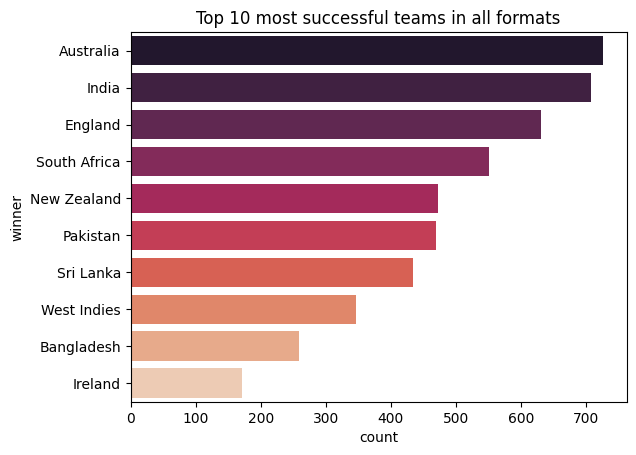

In [129]:
# Top 10 most successful teams in all formats
matches_won = pd.concat([test_summary,odi_summary,t20_summary],axis=0)
matches_won = matches_won[matches_won.winner!='No Result']
match = pd.DataFrame(matches_won.groupby('winner')['winner'].count())
match = match.rename(columns={'winner':'count'})
match.reset_index(inplace=True)
match = match.sort_values(by='count',ascending=False)
match.reset_index(drop=True,inplace=True)
match = match[0:10]
sns.barplot(match,x='count',y='winner',hue='winner',palette='rocket')
plt.title("Top 10 most successful teams in all formats")
plt.show()

**Chart - 2**

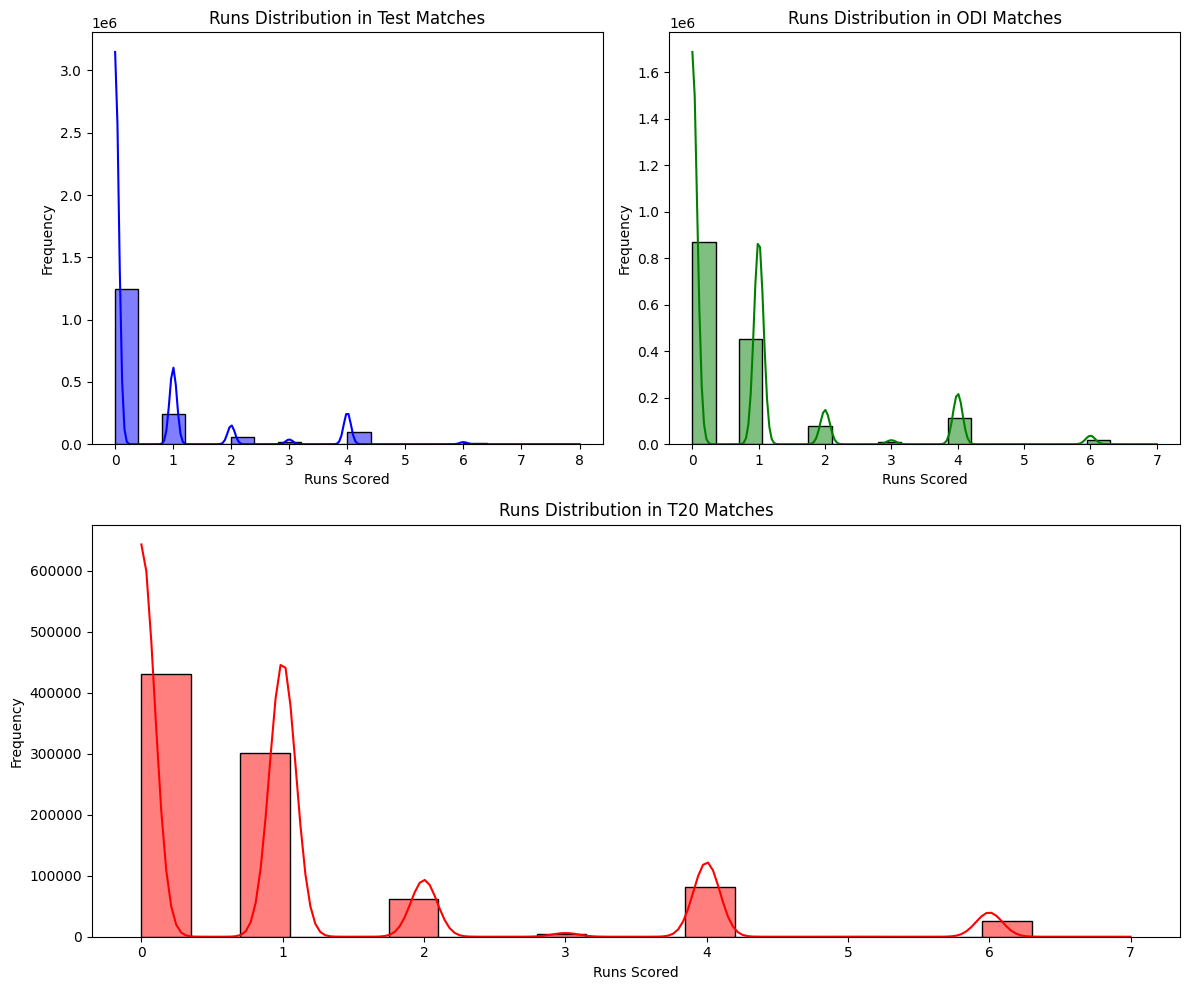

In [157]:
# Create a figure
fig = plt.figure(figsize=(12, 10))

# Test Matches Histogram (Top-Left)
ax1 = fig.add_subplot(2, 2, 1)  # First row, first column
sns.histplot(test_innings["runs_scored"], bins=20, kde=True, color="blue", ax=ax1)
ax1.set_title("Runs Distribution in Test Matches")
ax1.set_xlabel("Runs Scored")
ax1.set_ylabel("Frequency")

# ODI Matches Histogram (Top-Right)
ax2 = fig.add_subplot(2, 2, 2)  # First row, second column
sns.histplot(odi_innings["runs_scored"], bins=20, kde=True, color="green", ax=ax2)
ax2.set_title("Runs Distribution in ODI Matches")
ax2.set_xlabel("Runs Scored")
ax2.set_ylabel("Frequency")

# T20 Matches Histogram (Bottom-Center, spanning both columns)
ax3 = fig.add_subplot(2, 1, 2)  # Second row, spans full width
sns.histplot(t20_innings["runs_scored"], bins=20, kde=True, color="red", ax=ax3)
ax3.set_title("Runs Distribution in T20 Matches")
ax3.set_xlabel("Runs Scored")
ax3.set_ylabel("Frequency")

# Adjust layout
plt.tight_layout()
plt.show()

**Chart - 3**

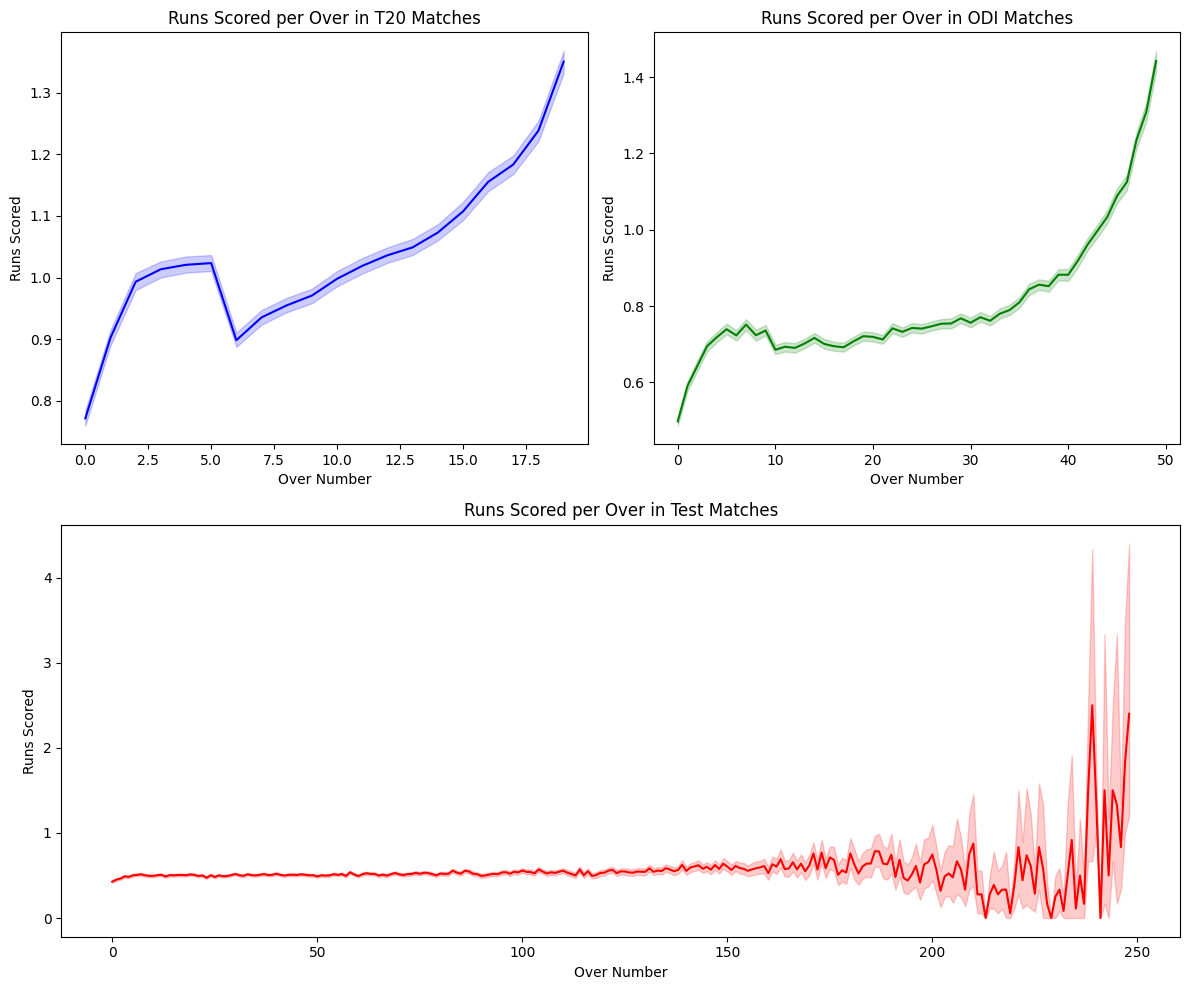

In [160]:
fig = plt.figure(figsize=(12, 10))

# Plot for T20 Matches
ax1 = fig.add_subplot(2, 2, 1)
sns.lineplot(x=t20_innings["over"], y=t20_innings["runs_scored"], color="blue", ax=ax1)
ax1.set_title("Runs Scored per Over in T20 Matches")
ax1.set_xlabel("Over Number")
ax1.set_ylabel("Runs Scored")

# Plot for ODI Matches
ax2 = fig.add_subplot(2, 2, 2)
sns.lineplot(x=odi_innings["over"], y=odi_innings["runs_scored"], color="green", ax=ax2)
ax2.set_title("Runs Scored per Over in ODI Matches")
ax2.set_xlabel("Over Number")
ax2.set_ylabel("Runs Scored")

# Plot for Test Matches
ax3 = fig.add_subplot(2, 1, 2)
sns.lineplot(x=test_innings["over"], y=test_innings["runs_scored"], color="red", ax=ax3)
ax3.set_title("Runs Scored per Over in Test Matches")
ax3.set_xlabel("Over Number")
ax3.set_ylabel("Runs Scored")

plt.tight_layout()
plt.show()

**Chart - 4**

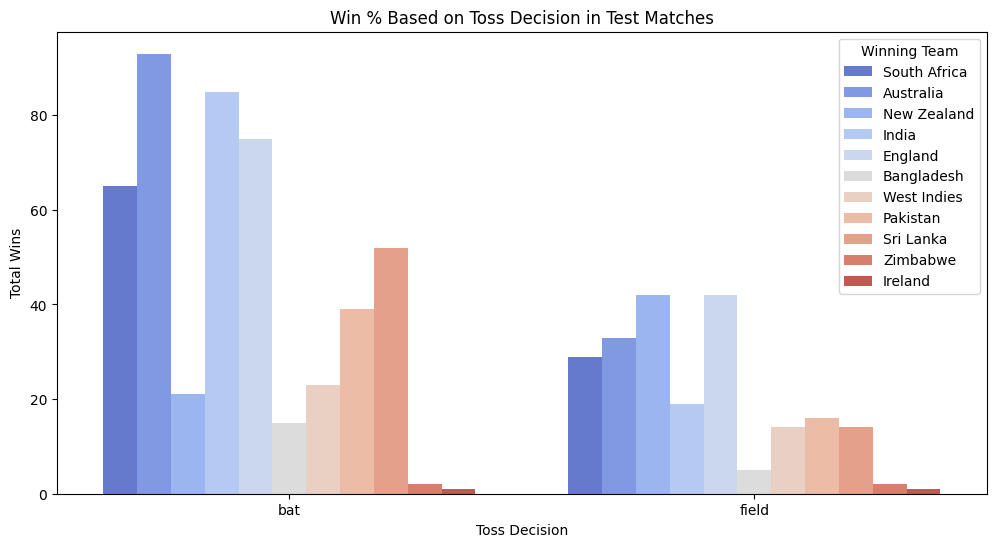

In [232]:
plt.figure(figsize=(12, 6))
test_sumup = test_summary[test_summary.winner!='No Result']
sns.countplot(x=test_sumup["toss_decision"], hue=test_sumup["winner"], palette="coolwarm")
plt.title("Win % Based on Toss Decision in Test Matches")
plt.xlabel("Toss Decision")
plt.ylabel("Total Wins")
plt.legend(title="Winning Team")
plt.show()

**Chart - 5**

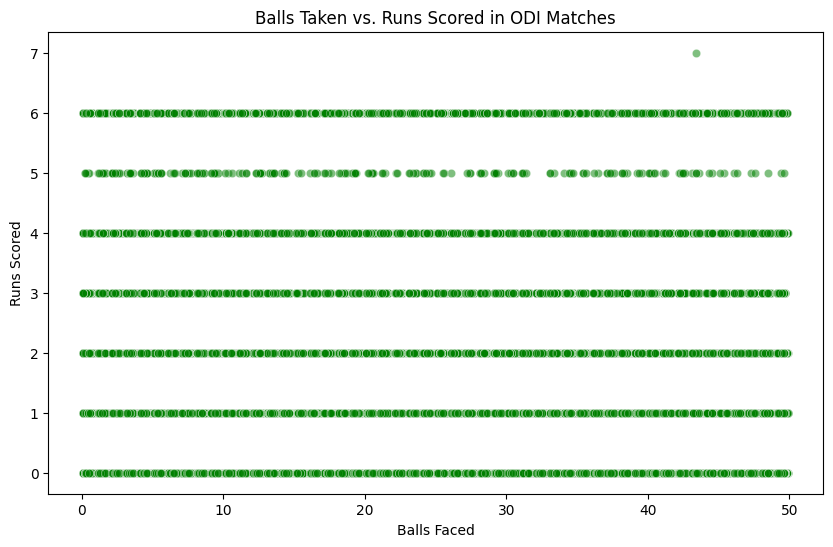

In [21]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=odi_innings["ball_number"], y=odi_innings["runs_scored"], alpha=0.5, color="green")
plt.title("Balls Taken vs. Runs Scored in ODI Matches")
plt.xlabel("Balls Faced")
plt.ylabel("Runs Scored")
plt.show()

**Chart - 6**

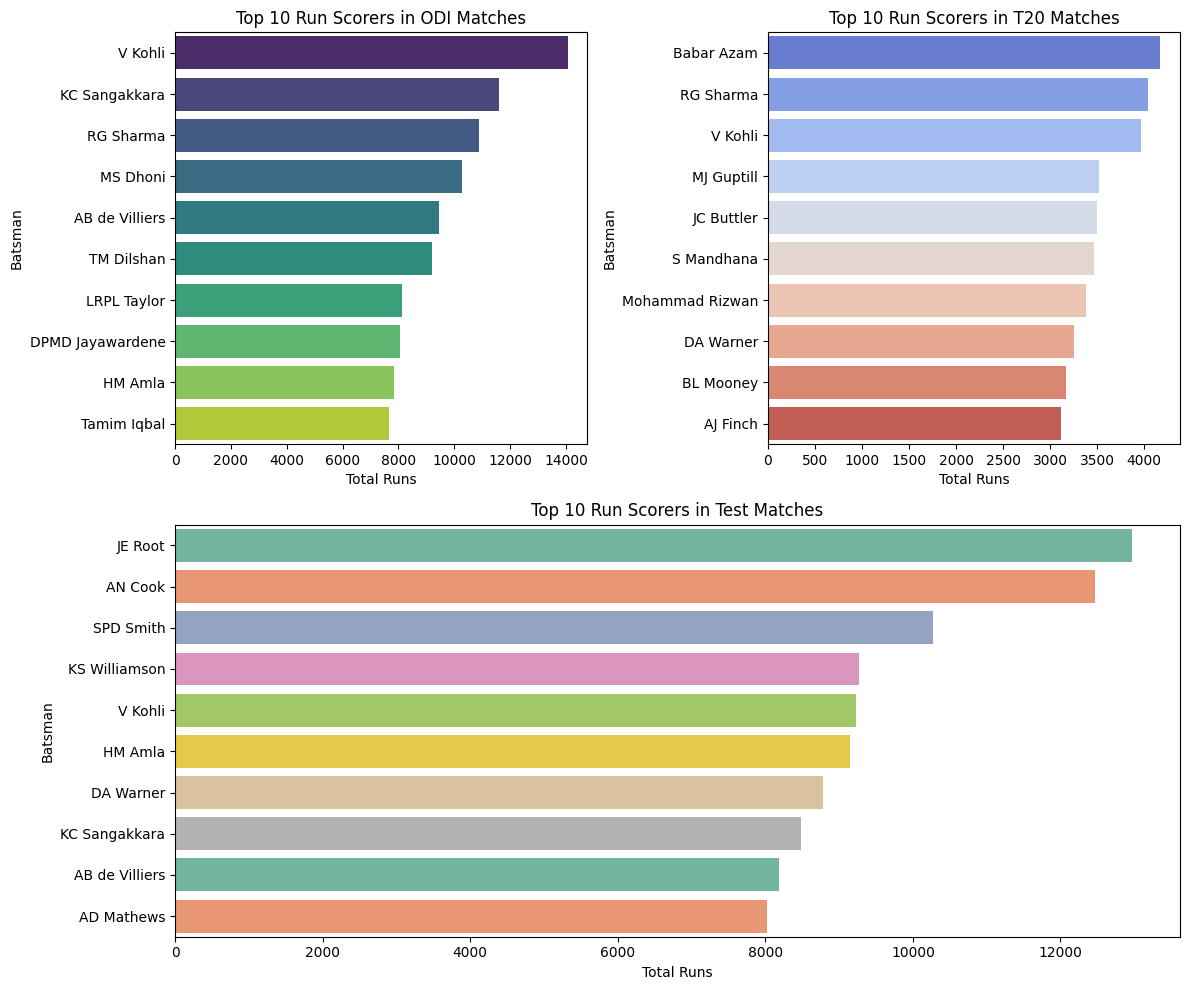

In [229]:
top_scorers = odi_innings.groupby("batsman")["runs_scored"].sum().reset_index()
top_scorers = top_scorers.sort_values("runs_scored", ascending=False).head(10)

fig = plt.figure(figsize=(12, 10))
ax1 = fig.add_subplot(2, 2, 1)
sns.barplot(x=top_scorers["runs_scored"], y=top_scorers["batsman"],hue=top_scorers["batsman"], palette="viridis",ax=ax1)
ax1.set_title("Top 10 Run Scorers in ODI Matches")
ax1.set_xlabel("Total Runs")
ax1.set_ylabel("Batsman")

top_scorers_t20 = t20_innings.groupby("batsman")["runs_scored"].sum().reset_index()
top_scorers_t20 = top_scorers_t20.sort_values("runs_scored", ascending=False).head(10)
ax2 = fig.add_subplot(2, 2, 2)
sns.barplot(x=top_scorers_t20["runs_scored"], y=top_scorers_t20["batsman"],hue=top_scorers_t20["batsman"], palette="coolwarm",ax=ax2)
ax2.set_title("Top 10 Run Scorers in T20 Matches")
ax2.set_xlabel("Total Runs")
ax2.set_ylabel("Batsman")

top_scorers_test = test_innings.groupby("batsman")["runs_scored"].sum().reset_index()
top_scorers_test = top_scorers_test.sort_values("runs_scored", ascending=False).head(10)
ax3 = fig.add_subplot(2, 1, 2)
sns.barplot(x=top_scorers_test["runs_scored"], y=top_scorers_test["batsman"],hue=top_scorers_test["batsman"], palette="Set2",ax=ax3)
ax3.set_title("Top 10 Run Scorers in Test Matches")
ax3.set_xlabel("Total Runs")
ax3.set_ylabel("Batsman")

plt.tight_layout()
plt.show()

**Chart - 7**

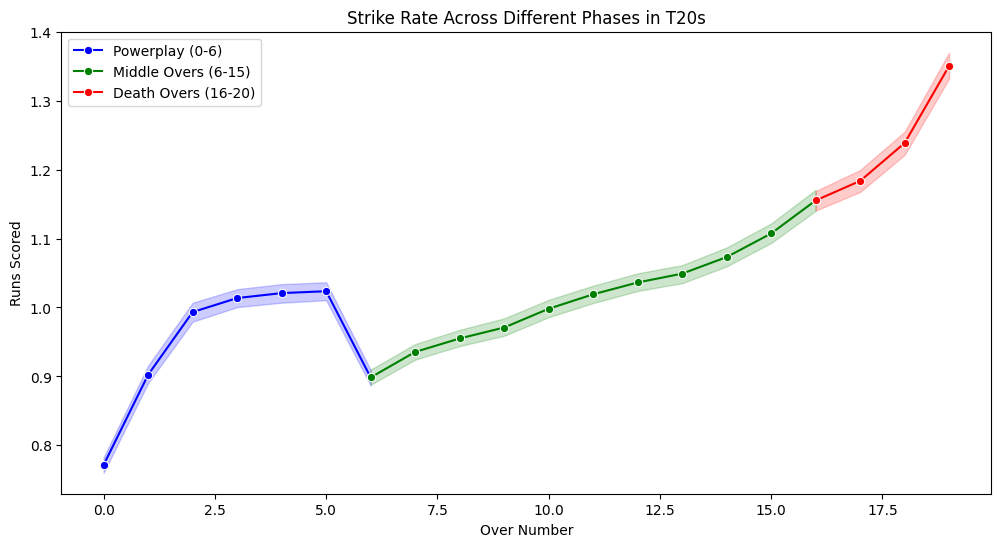

In [238]:
# Filter different phases
df_t20_powerplay = t20_innings[t20_innings["over"] <= 6]
df_t20_middle = t20_innings[(t20_innings["over"] >= 6) & (t20_innings["over"] <= 16)]
df_t20_death = t20_innings[t20_innings["over"] >= 16]

plt.figure(figsize=(12, 6))

# Plot each phase separately
sns.lineplot(x=df_t20_powerplay["over"], y=df_t20_powerplay["runs_scored"], label="Powerplay (0-6)", color="blue", marker="o")
sns.lineplot(x=df_t20_middle["over"], y=df_t20_middle["runs_scored"], label="Middle Overs (6-15)", color="green", marker="o")
sns.lineplot(x=df_t20_death["over"], y=df_t20_death["runs_scored"], label="Death Overs (16-20)", color="red", marker="o")

# Titles and labels
plt.title("Strike Rate Across Different Phases in T20s")
plt.xlabel("Over Number")
plt.ylabel("Runs Scored")
plt.legend()
plt.show()

**Chart - 8**

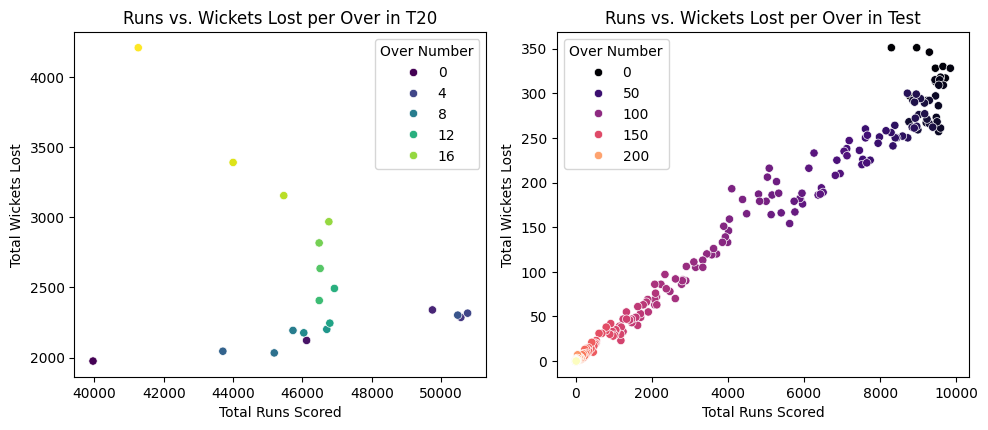

In [20]:
# Create a 'wickets_lost' column: 1 if wicket_type is NOT "not out", else 0
t20_innings["wickets_lost"] = (t20_innings["wicket_type"] != "Not Out").astype(int)
test_innings["wickets_lost"] = (test_innings["wicket_type"] != "Not Out").astype(int)

# Aggregate total runs and total wickets per over
df_wickets_per_over_t20 = t20_innings.groupby("over").agg(
    total_runs=("runs_scored", "sum"),
    total_wickets=("wickets_lost", "sum")
).reset_index()

df_wickets_per_over_test = test_innings.groupby("over").agg(
    total_runs=("runs_scored", "sum"),
    total_wickets=("wickets_lost", "sum")
).reset_index()

# Scatter plot with aggregated values
fig, ax = plt.subplots(2, 2, figsize=(10,8))
sns.scatterplot(
    x=df_wickets_per_over_t20["total_runs"], 
    y=df_wickets_per_over_t20["total_wickets"], 
    hue=df_wickets_per_over_t20["over"], 
    palette="viridis",
    ax = ax[0,0]
)
ax[0,0].set_title("Runs vs. Wickets Lost per Over in T20")
ax[0,0].set_xlabel("Total Runs Scored")
ax[0,0].set_ylabel("Total Wickets Lost")
ax[0,0].legend(title="Over Number")

sns.scatterplot(
    x=df_wickets_per_over_test["total_runs"], 
    y=df_wickets_per_over_test["total_wickets"], 
    hue=df_wickets_per_over_test["over"], 
    palette="magma",
    ax = ax[0,1]
)
ax[0,1].set_title("Runs vs. Wickets Lost per Over in Test")
ax[0,1].set_xlabel("Total Runs Scored")
ax[0,1].set_ylabel("Total Wickets Lost")
ax[0,1].legend(title="Over Number")

fig.delaxes(ax[1,0])
fig.delaxes(ax[1,1])

plt.tight_layout()
plt.show()

**Chart - 9**

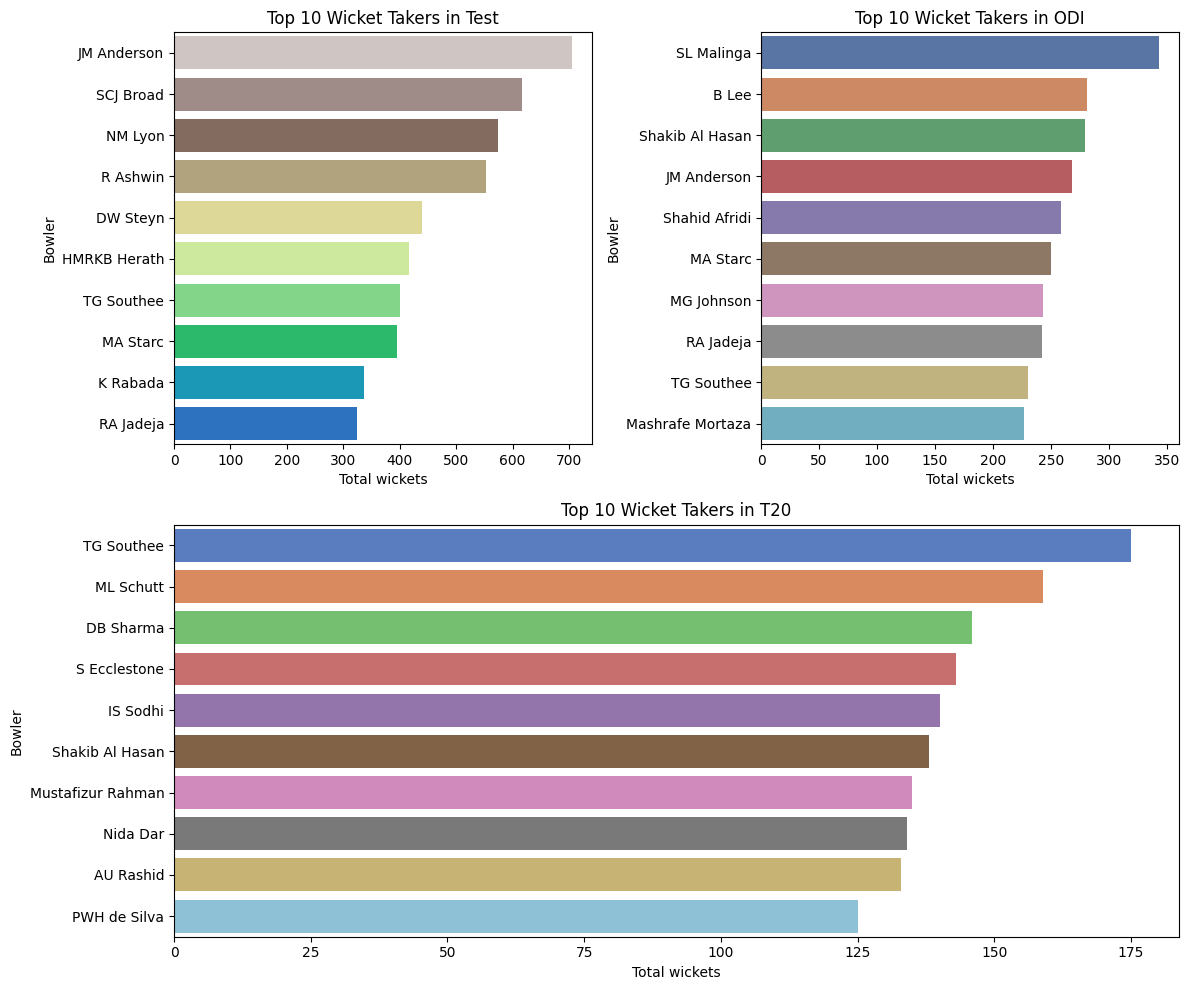

In [26]:
test_wickets = test_innings[test_innings['wicket_type']!='Not Out']
top_bowlers_test = test_wickets["bowler"].value_counts().head(10)

odi_wickets = odi_innings[odi_innings['wicket_type']!='Not Out']
top_bowlers_odi = odi_wickets["bowler"].value_counts().head(10)

t20_wickets = t20_innings[t20_innings['wicket_type']!='Not Out']
top_bowlers_t20 = t20_wickets["bowler"].value_counts().head(10)

fig = plt.figure(figsize=(12, 10))
ax1 = fig.add_subplot(2, 2, 1)
sns.barplot(x=top_bowlers_test.values,y=top_bowlers_test.index,hue=top_bowlers_test.index,palette='terrain_r',ax=ax1)
ax1.set_xlabel('Total wickets')
ax1.set_ylabel('Bowler')
ax1.set_title('Top 10 Wicket Takers in Test')

ax2 = fig.add_subplot(2, 2, 2)
sns.barplot(x=top_bowlers_odi.values,y=top_bowlers_odi.index,hue=top_bowlers_odi.index,palette='deep',ax=ax2)
ax2.set_xlabel('Total wickets')
ax2.set_ylabel('Bowler')
ax2.set_title('Top 10 Wicket Takers in ODI')

ax3 = fig.add_subplot(2, 1, 2)
sns.barplot(x=top_bowlers_t20.values,y=top_bowlers_t20.index,hue=top_bowlers_t20.index,palette='muted',ax=ax3)
ax3.set_xlabel('Total wickets')
ax3.set_ylabel('Bowler')
ax3.set_title('Top 10 Wicket Takers in T20')

plt.tight_layout()
plt.show()

**Chart - 10**

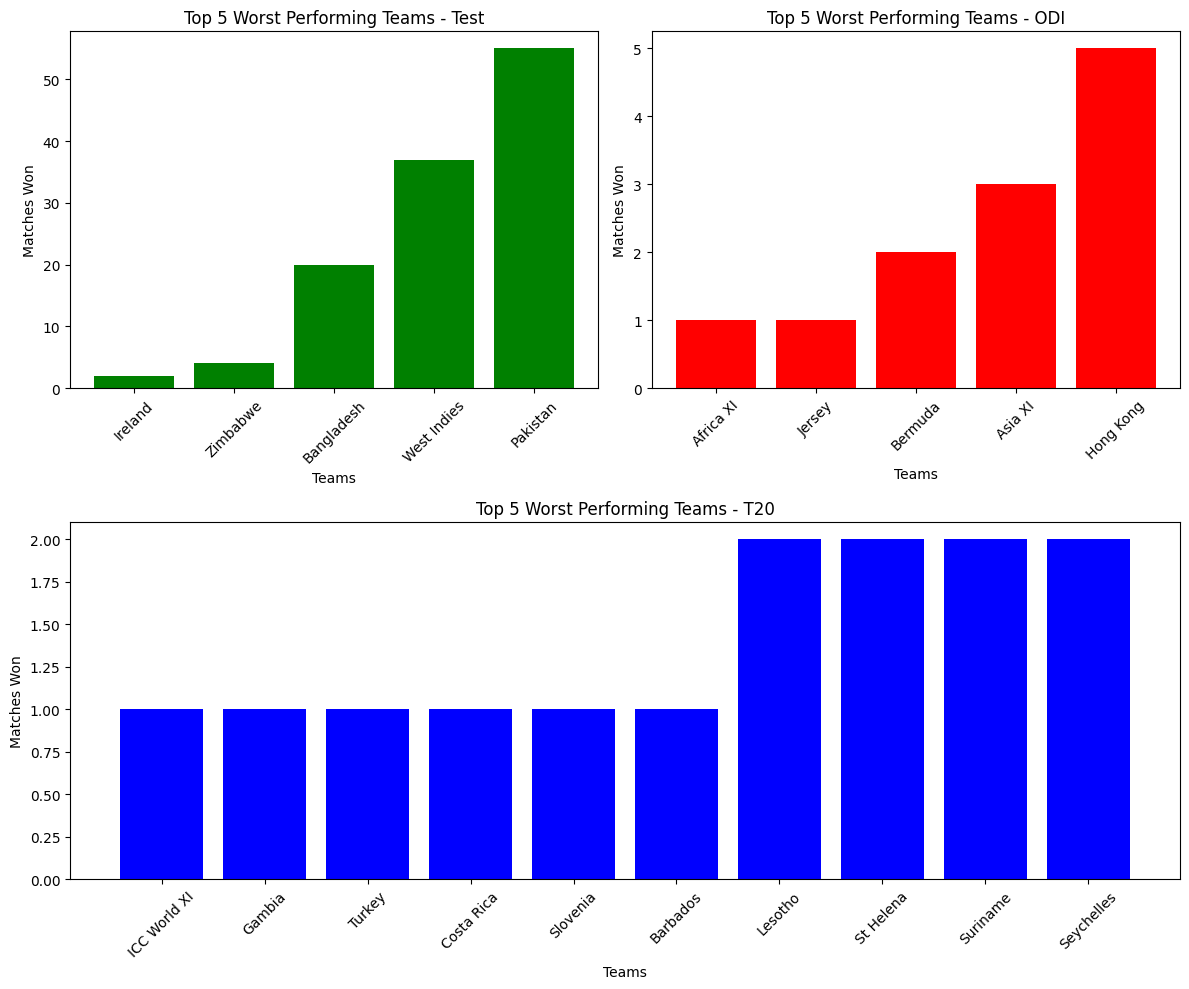

In [44]:
test_worst = test_summary[test_summary.winner!='No Result'].groupby('winner').agg(wins=("winner","count"))
test_worst.reset_index(inplace=True)
test_worst = test_worst.sort_values(by='wins')
test_worst = test_worst.head()
test_worst.reset_index(drop=True,inplace=True)

odi_worst = odi_summary[odi_summary.winner!='No Result'].groupby('winner').agg(wins=("winner","count"))
odi_worst.reset_index(inplace=True)
odi_worst = odi_worst.sort_values(by='wins')
odi_worst = odi_worst.head()
odi_worst.reset_index(drop=True,inplace=True)

t20_worst = t20_summary[t20_summary.winner!='No Result'].groupby('winner').agg(wins=("winner","count"))
t20_worst.reset_index(inplace=True)
t20_worst = t20_worst.sort_values(by='wins')
t20_worst = t20_worst.head(10)
t20_worst.reset_index(drop=True,inplace=True)

fig = plt.figure(figsize=(12, 10))
ax1 = fig.add_subplot(2, 2, 1)
ax1.bar(test_worst['winner'],test_worst['wins'],color='green')
ax1.set_title("Top 5 Worst Performing Teams - Test")
ax1.set_xlabel("Teams")
ax1.set_ylabel("Matches Won")
ax1.tick_params(axis='x', rotation=45)

ax2 = fig.add_subplot(2, 2, 2)
ax2.bar(odi_worst['winner'],odi_worst['wins'],color='red')
ax2.set_title("Top 5 Worst Performing Teams - ODI")
ax2.set_xlabel("Teams")
ax2.set_ylabel("Matches Won")
ax2.tick_params(axis='x', rotation=45)

ax3 = fig.add_subplot(2, 1, 2)
ax3.bar(t20_worst['winner'],t20_worst['wins'],color='blue')
ax3.set_title("Top 10 Worst Performing Teams - T20")
ax3.set_xlabel("Teams")
ax3.set_ylabel("Matches Won")
ax3.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [45]:
i=1
f"Chart - {i}"

'Chart - 1'